In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
from scipy.fft import fft, fftfreq
import json

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


c:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [2]:
# %aimport experiments
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_F0G1
imported experiments.

In [3]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [4]:
expt_path=os.path.join(os.getcwd(), 'data', 'data_240218')
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_240218


In [5]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.path.join(os.getcwd(), config_file)
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond_full688and638_reset.yml


Load config

In [80]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [71]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

In [72]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print('set freq to', lo_freq)
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

Default Instrument SC_26C1
set freq to 5925000000.0
set power to 15.0


In [73]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Software version: 0.2.207
	Firmware timestamp: Mon Jul 24 13:57:32 2023

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 65536 samples
		DAC tile 2, blk 0, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, blk 1, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	2:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, blk 2, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	3:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, blk 3, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC ti

# Sweep qubits to get 4x4 ZZ matrix

For each iteration: sweep qubit 0 freq after applying pi pulse to qubit 1

In [77]:
ZZshifts = np.zeros((4,4)) # first dim: qubit 0, second dim: qubit 1

Baseline qspec - optional

In [ ]:
qfreqs = []
qubit0 = 1
for qubit1 in range(1):
# for qubit0 in range(4):
    qspec = meas.PulseProbeCouplingSpectroscopyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"qubit_coupling_spectroscopy_qubit{qubit0}",
        config_file=config_path,
    )
    
    span = 10
    npts = 151
    
    qspec.cfg.expt = dict(
        start=qspec.cfg.device.qubit.f_ge[qubit0]-span/2,
        # start=3600,
        step=span/npts,
        expts=npts, # Number of experiments stepping from start
        reps=100, # Number of averages per point
        rounds=20, # Number of start to finish sweeps to average over
        pulseB=True, # Whether to apply pi pulse to qubit B
        length=1, # qubit 0 probe constant pulse length [us]
        gain=int(qspec.cfg.device.qubit.pulses.pi_ge.gain[qubit0]/15), # Qubit pulse gain
        pulse_type='gauss',
        qubits=[qubit0, qubit1],
    )
    
    # qspec.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]
    
    # print(qspec.cfg)
    
    qspec.go(analyze=False, display=False, progress=True, save=False)

    # ============ POST PROCESSING ============ #
    best_signs = [1, 0, 0]
    best_fit_err_i = np.inf
    best_fit_err_q = np.inf
    for sign in [1, -1]:
        try: 
            qspec.analyze(fit=True, signs=[1, sign, sign])
            fit_err_amps = qspec.data['fit_err_amps'][2][2]
            fit_err_i = qspec.data['fit_err_avgi'][2][2]
            fit_err_q = qspec.data['fit_err_avgq'][2][2]
            if fit_err_i < best_fit_err_i:
                best_signs[1] = sign
                best_fit_err_i = fit_err_i
            if fit_err_q < best_fit_err_q:
                best_signs[2] = sign
                best_fit_err_q = fit_err_q
        except: continue
    if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
        qspec.display(fit=False)
        print(f'WARNING: All fits failed for Q{qubit0}, please manually fix!')
        continue

    qspec.analyze(fit=True, signs=best_signs)
    qspec.display(fit=True, signs=best_signs)

    qspec_fit, qspec_fit_err = meas.fitting.get_best_fit(qspec.data)
    qfreqs.append(qspec_fit[2])
    print(f'Fit Q{qubit0} frequency [MHz]: {qspec_fit[2]}')

print('Qubit freqs', qfreqs)

ZZ shifts

qTest 0 qZZ 1
-------- Ramsey --------


  0%|          | 0/10 [00:00<?, ?it/s]

2
Current pi pulse frequency: 4111.357154037054
Fit frequency from amps [MHz]: 2.5026181809335832 +/- 0.0013164279144601888
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4111.3545358561205
 	4106.3545358561205
T2 Ramsey from fit amps [us]: 56.53180315039407
Current pi pulse frequency: 4111.357154037054
Fit frequency from I [MHz]: 2.502909614071655 +/- 0.0022948799276376794
Suggested new pi pulse frequency from fit I [MHz]:
 	4111.354244422982
 	4106.354244422982
T2 Ramsey from fit I [us]: 64.43490858937174
Fit frequency from Q [MHz]: 2.5025720561660365 +/- 0.0012590359374152565
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4111.354581980888
 	4106.354581980888
T2 Ramsey from fit Q [us]: 55.72948785622659


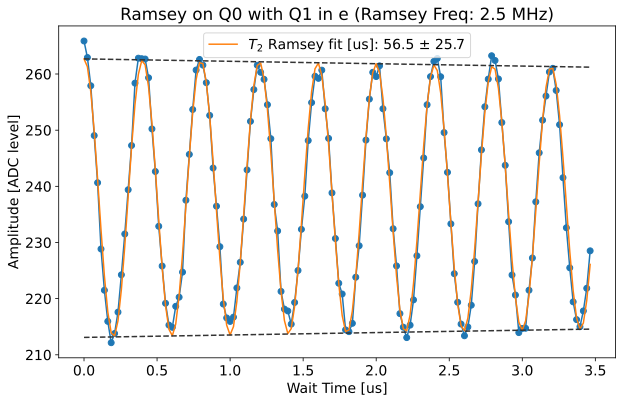

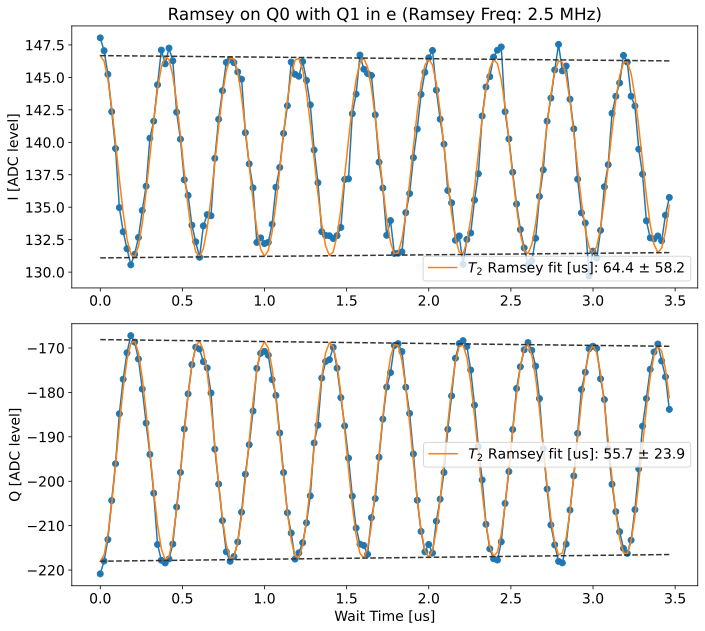

*Set Q0 shift due to Q1 in e to -5.247353163402295*
qTest 0 qZZ 2
-------- Ramsey --------
zz shifted freqs for Q0 [4116.62788350742, 4111.383102400184, 4116.32788350742, 4116.09781233742]


  0%|          | 0/10 [00:00<?, ?it/s]

0
Current pi pulse frequency: 4116.32788350742
Fit frequency from amps [MHz]: 2.3368058679066657 +/- 0.0009500706541087401
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4116.491077639513
 	4111.491077639513
T2 Ramsey from fit amps [us]: 13.931664825504361
Current pi pulse frequency: 4116.32788350742
Fit frequency from I [MHz]: 2.3363036337257737 +/- 0.0017044665217702943
Suggested new pi pulse frequency from fit I [MHz]:
 	4116.491579873694
 	4111.491579873694
T2 Ramsey from fit I [us]: 14.40947087630695
Fit frequency from Q [MHz]: 2.3369765303583656 +/- 0.0009878419557474171
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4116.490906977061
 	4111.490906977061
T2 Ramsey from fit Q [us]: 13.816067690778729


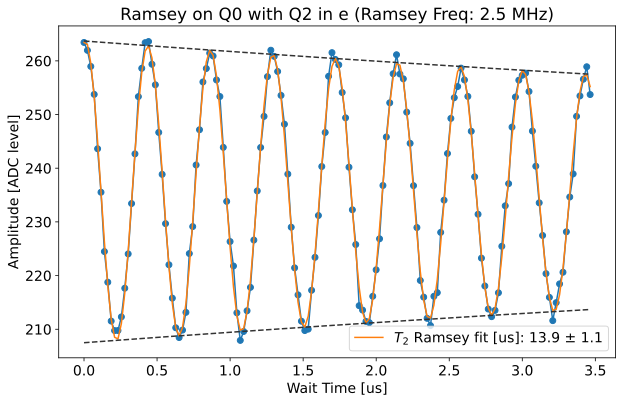

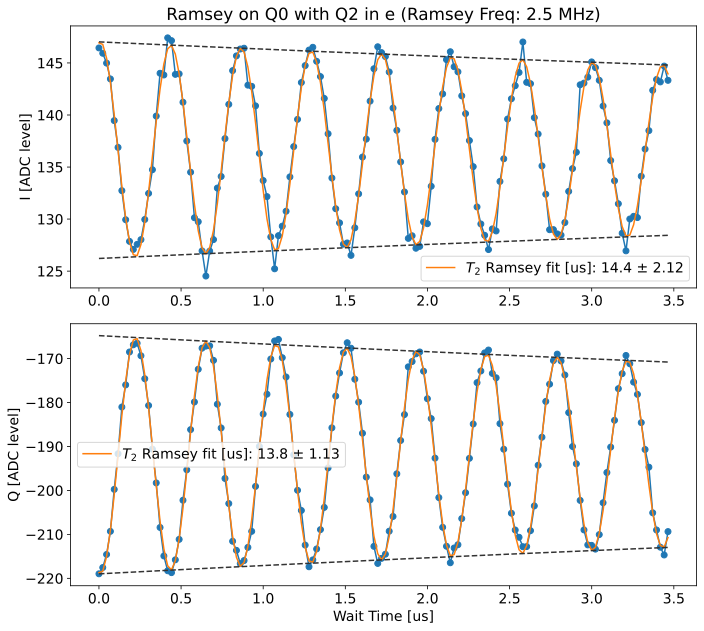

*Set Q0 shift due to Q2 in e to -0.13680586790724192*
qTest 0 qZZ 3
-------- Ramsey --------
zz shifted freqs for Q0 [4116.62788350742, 4111.383102400184, 4116.32788350742, 4116.09781233742]


  0%|          | 0/10 [00:00<?, ?it/s]

2
Current pi pulse frequency: 4116.09781233742
Fit frequency from amps [MHz]: 2.5332188367408346 +/- 0.001110010697075181
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4116.064593500679
 	4111.064593500679
T2 Ramsey from fit amps [us]: 15.337704068920177
Current pi pulse frequency: 4116.09781233742
Fit frequency from I [MHz]: 2.5320113125476498 +/- 0.0017591187785076035
Suggested new pi pulse frequency from fit I [MHz]:
 	4116.065801024872
 	4111.065801024872
T2 Ramsey from fit I [us]: 16.242256402792577
Fit frequency from Q [MHz]: 2.5335625044361856 +/- 0.001127722014000541
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4116.0642498329835
 	4111.0642498329835
T2 Ramsey from fit Q [us]: 15.104619288232257


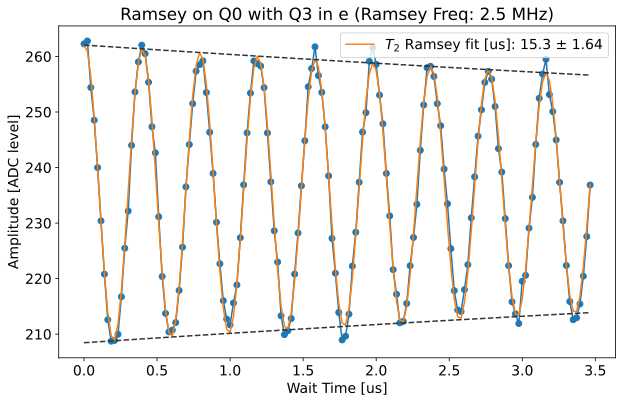

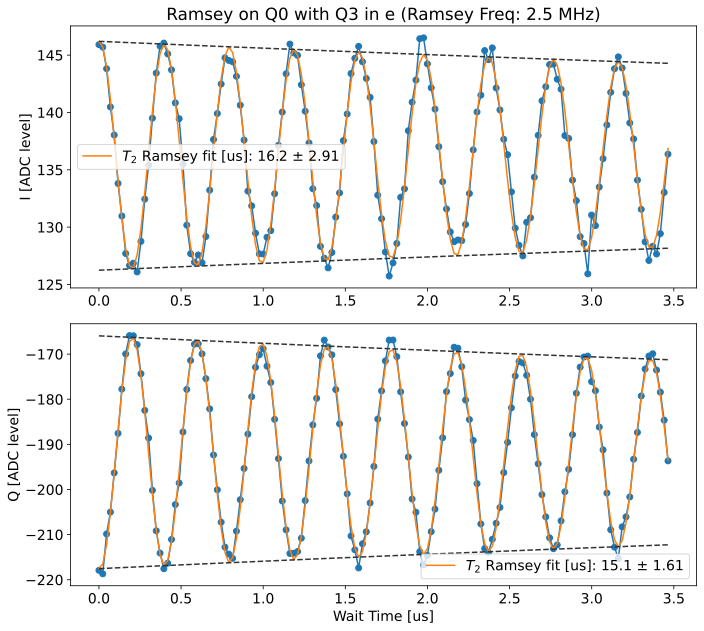

*Set Q0 shift due to Q3 in e to -0.5636336744364598*
qTest 1 qZZ 0
-------- Ramsey --------


  0%|          | 0/10 [00:00<?, ?it/s]

2
Current pi pulse frequency: 3445.1695202603087
Fit frequency from amps [MHz]: 2.5033311081773526 +/- 0.0015188310918420789
Suggested new pi pulse frequencies from fit amps [MHz]:
 	3445.166189152131
 	3440.166189152131
T2 Ramsey from fit amps [us]: 80.62160377672386
Current pi pulse frequency: 3445.1695202603087
Fit frequency from I [MHz]: 2.507108169504835 +/- 0.002925446274060114
Suggested new pi pulse frequency from fit I [MHz]:
 	3445.1624120908036
 	3440.1624120908036
T2 Ramsey from fit I [us]: 35.38828381009516
Fit frequency from Q [MHz]: 2.502564135395353 +/- 0.0015547535731319066
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3445.166956124913
 	3440.166956124913
T2 Ramsey from fit Q [us]: 64.33492512062958


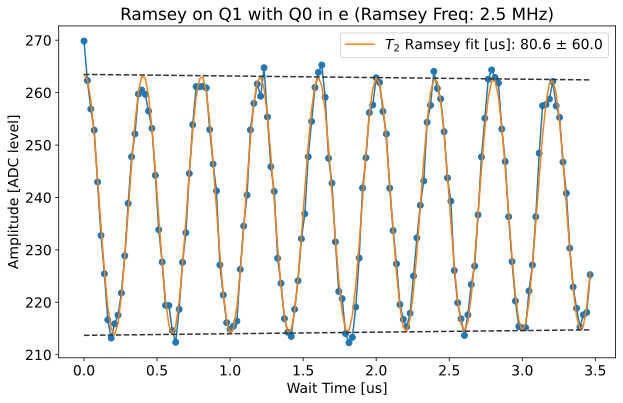

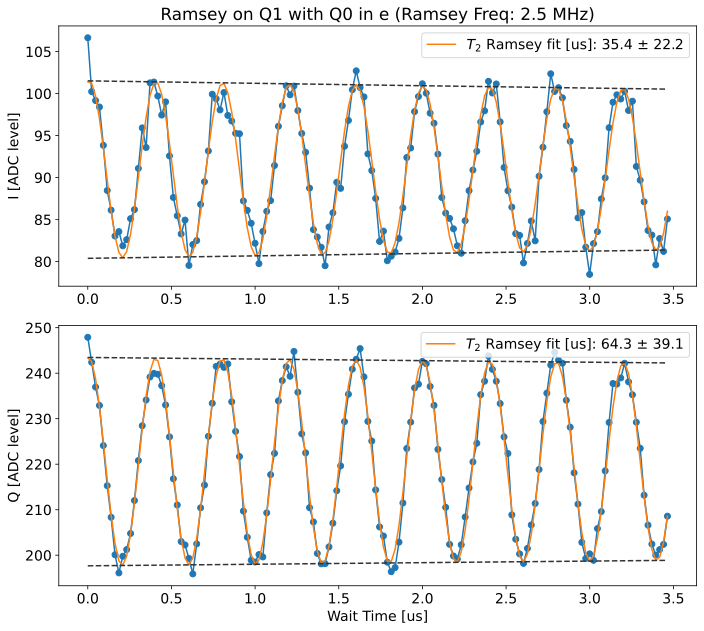

*Set Q1 shift due to Q0 in e to -5.274533978365071*
qTest 1 qZZ 2
-------- Ramsey --------


  0%|          | 0/10 [00:00<?, ?it/s]

0
Current pi pulse frequency: 3449.3409621315604
Fit frequency from amps [MHz]: 2.495982540840435 +/- 0.0016927276174784345
Suggested new pi pulse frequencies from fit amps [MHz]:
 	3449.34497959072
 	3444.34497959072
T2 Ramsey from fit amps [us]: 29.72474763538667
Current pi pulse frequency: 3449.3409621315604
Fit frequency from I [MHz]: 2.4945542144086272 +/- 0.0031292667136263563
Suggested new pi pulse frequency from fit I [MHz]:
 	3449.3464079171517
 	3444.3464079171517
T2 Ramsey from fit I [us]: 21.20570565715715
Fit frequency from Q [MHz]: 2.4962588800070242 +/- 0.0017847288159409584
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3449.3447032515533
 	3444.3447032515533
T2 Ramsey from fit Q [us]: 32.04751608953551


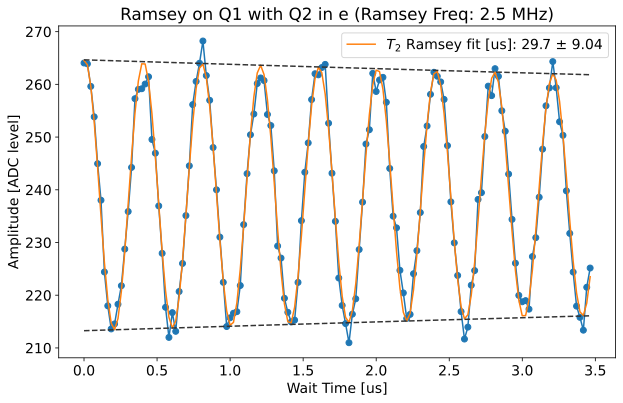

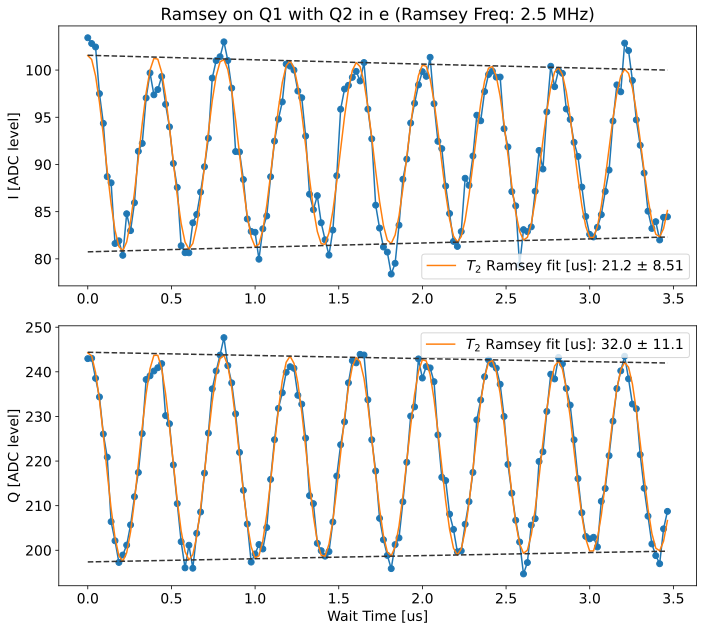

*Set Q1 shift due to Q2 in e to -1.086931693679162*
qTest 1 qZZ 3
-------- Ramsey --------


  0%|          | 0/10 [00:00<?, ?it/s]

0
Current pi pulse frequency: 3449.179169646872
Fit frequency from amps [MHz]: 2.534775531532186 +/- 0.0014932863849236957
Suggested new pi pulse frequencies from fit amps [MHz]:
 	3449.14439411534
 	3444.14439411534
T2 Ramsey from fit amps [us]: 20.097971315286323
Current pi pulse frequency: 3449.179169646872
Fit frequency from I [MHz]: 2.5349718709151086 +/- 0.0024356154392306253
Suggested new pi pulse frequency from fit I [MHz]:
 	3449.1441977759573
 	3444.1441977759573
T2 Ramsey from fit I [us]: 23.759126164525572
Fit frequency from Q [MHz]: 2.5347616354985796 +/- 0.0016159759944322182
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3449.144408011374
 	3444.144408011374
T2 Ramsey from fit Q [us]: 19.432122196744615


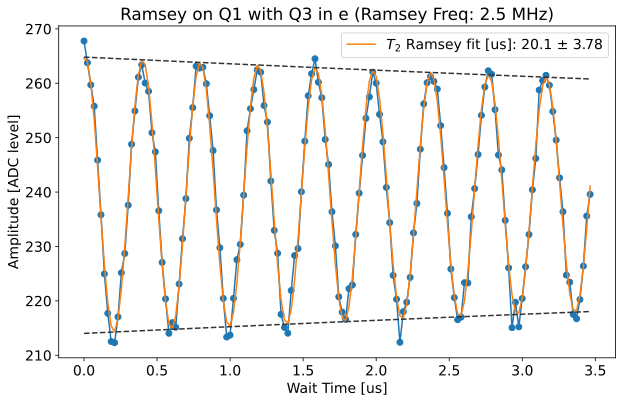

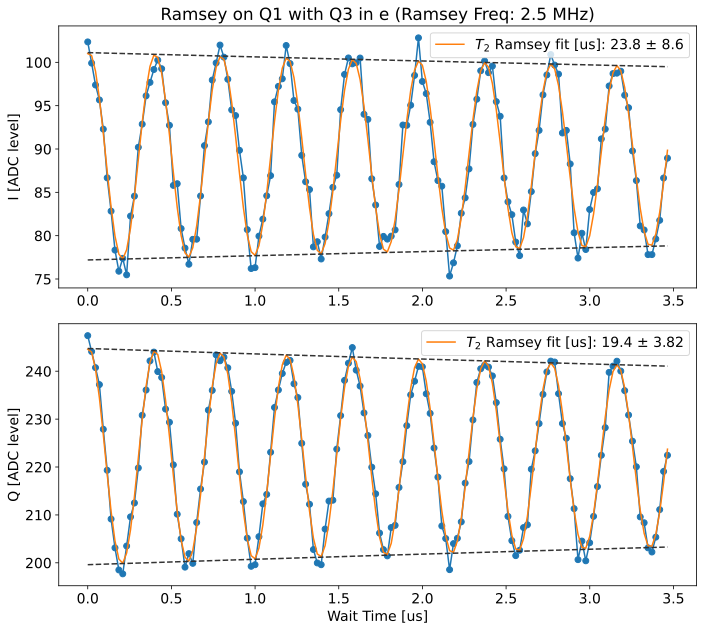

*Set Q1 shift due to Q3 in e to -1.3240606637937162*
qTest 2 qZZ 0
-------- Ramsey --------
zz shifted freqs for Q2 [4766.416788201259, 4765.446645017305, 4766.546959121259, 4766.0323868712585]


  0%|          | 0/10 [00:00<?, ?it/s]

2
Current pi pulse frequency: 4766.416788201259
Fit frequency from amps [MHz]: 2.5630152961837425 +/- 0.001202172351503096
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4766.353772905075
 	4761.353772905075
T2 Ramsey from fit amps [us]: 15.343571220494594
Current pi pulse frequency: 4766.416788201259
Fit frequency from I [MHz]: 2.560334720996722 +/- 0.004287151871640922
Suggested new pi pulse frequency from fit I [MHz]:
 	4766.356453480262
 	4761.356453480262
T2 Ramsey from fit I [us]: 30.750622081349068
Fit frequency from Q [MHz]: 2.5631590534726008 +/- 0.0012204082103052158
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4766.353629147787
 	4761.353629147787
T2 Ramsey from fit Q [us]: 15.251439790662943


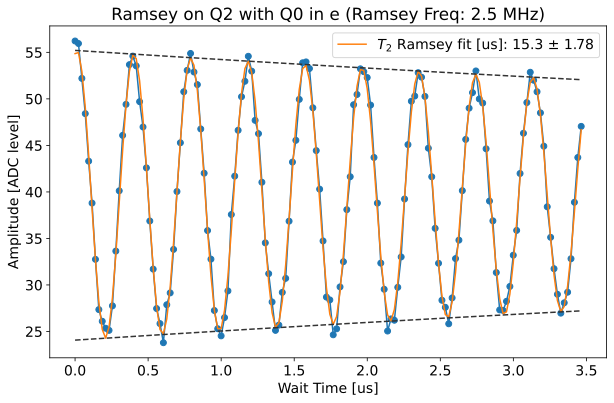

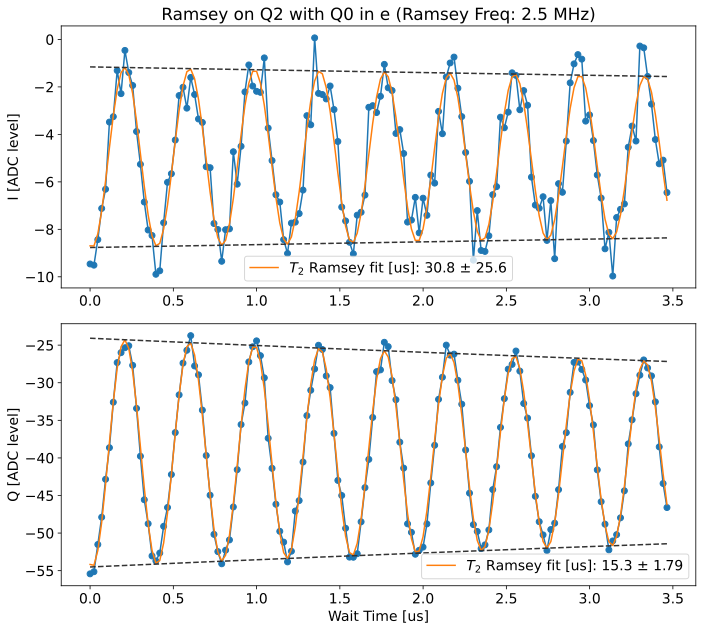

*Set Q2 shift due to Q0 in e to -0.1933299734719185*
qTest 2 qZZ 1
-------- Ramsey --------


  0%|          | 0/10 [00:00<?, ?it/s]

2
Current pi pulse frequency: 4765.446645017305
Fit frequency from amps [MHz]: 2.550559986213168 +/- 0.0018119011784693444
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4765.396085031091
 	4760.396085031091
T2 Ramsey from fit amps [us]: 16.72869622226768
Current pi pulse frequency: 4765.446645017305
Fit frequency from I [MHz]: 2.553921261002227 +/- 0.003975998333044491
Suggested new pi pulse frequency from fit I [MHz]:
 	4765.392723756303
 	4760.392723756303
T2 Ramsey from fit I [us]: 41.1082584284368
Fit frequency from Q [MHz]: 2.5504467756504274 +/- 0.0018125416727968755
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4765.396198241655
 	4760.396198241655
T2 Ramsey from fit Q [us]: 16.405424491045082


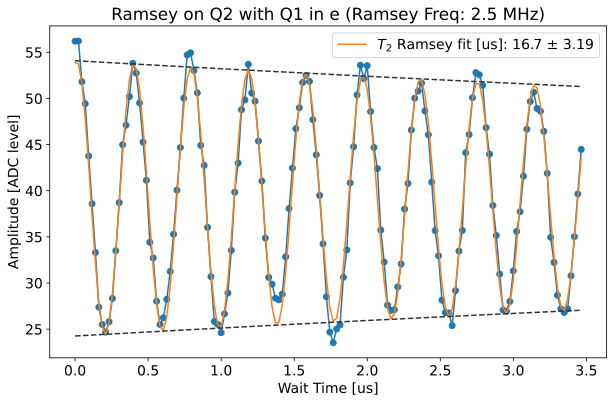

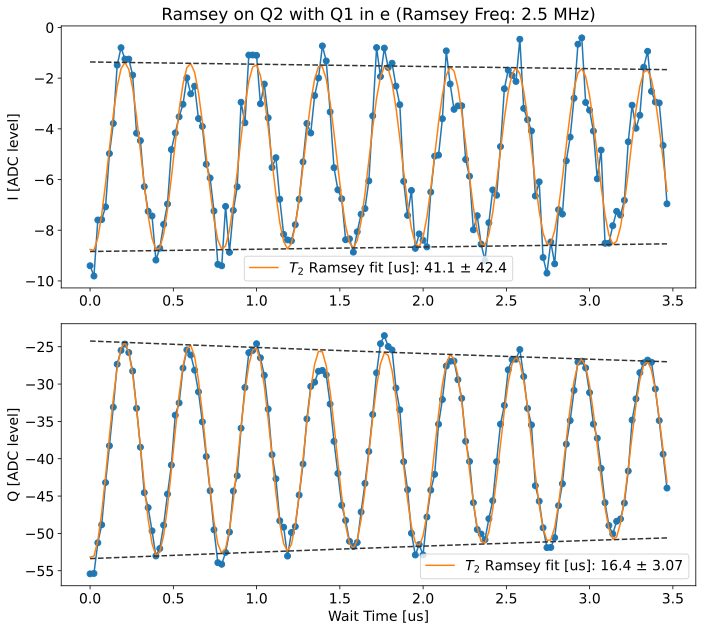

*Set Q2 shift due to Q1 in e to -1.1507608796036948*
qTest 2 qZZ 3
-------- Ramsey --------
zz shifted freqs for Q2 [4766.416788201259, 4765.446645017305, 4766.546959121259, 4766.0323868712585]


  0%|          | 0/10 [00:00<?, ?it/s]

0
Current pi pulse frequency: 4766.0323868712585
Fit frequency from amps [MHz]: 2.5512152572569744 +/- 0.0014060663871913494
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4765.981171614001
 	4760.981171614001
T2 Ramsey from fit amps [us]: 19.123726004640908
Current pi pulse frequency: 4766.0323868712585
Fit frequency from I [MHz]: 2.5538713709119767 +/- 0.004169095678059427
Suggested new pi pulse frequency from fit I [MHz]:
 	4765.9785155003465
 	4760.9785155003465
T2 Ramsey from fit I [us]: 12.72235077621734
Fit frequency from Q [MHz]: 2.5511156887897877 +/- 0.001428769445934523
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4765.981271182469
 	4760.981271182469
T2 Ramsey from fit Q [us]: 19.542030221941552


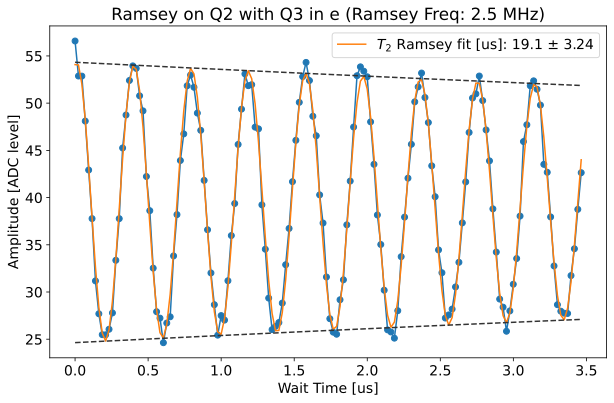

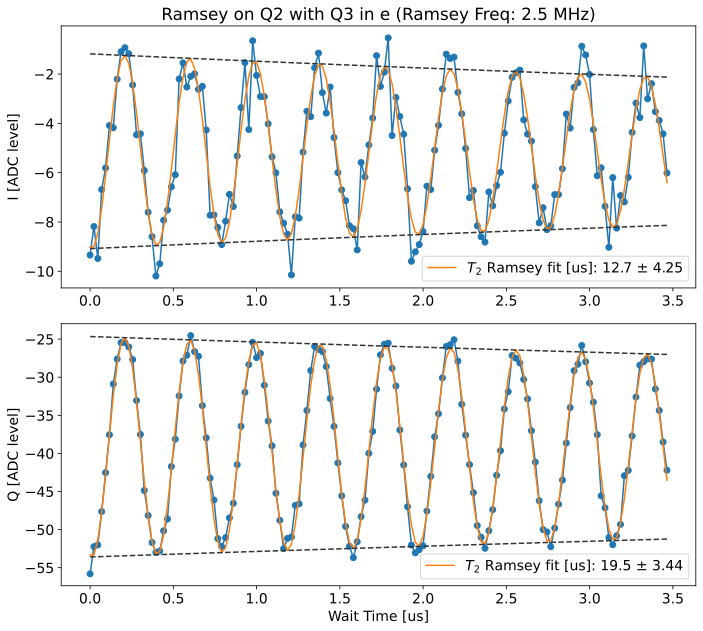

*Set Q2 shift due to Q3 in e to -0.5657875072574825*
qTest 3 qZZ 0
-------- Ramsey --------
zz shifted freqs for Q3 [4380.711552450314, 4379.930473089215, 4380.727051370314, 4381.241623620314]


  0%|          | 0/10 [00:00<?, ?it/s]

0
Current pi pulse frequency: 4380.711552450314
Fit frequency from amps [MHz]: 2.6156029035278094 +/- 0.001219114888171371
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4380.595949546787
 	4375.595949546787
T2 Ramsey from fit amps [us]: 16.27014203400515
Current pi pulse frequency: 4380.711552450314
Fit frequency from I [MHz]: 2.615857600514226 +/- 0.0014431215158950523
Suggested new pi pulse frequency from fit I [MHz]:
 	4380.5956948498
 	4375.5956948498
T2 Ramsey from fit I [us]: 15.749527531033252
Fit frequency from Q [MHz]: 2.615043634770452 +/- 0.0012325276443218031
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4380.5965088155435
 	4375.5965088155435
T2 Ramsey from fit Q [us]: 17.23007435497937


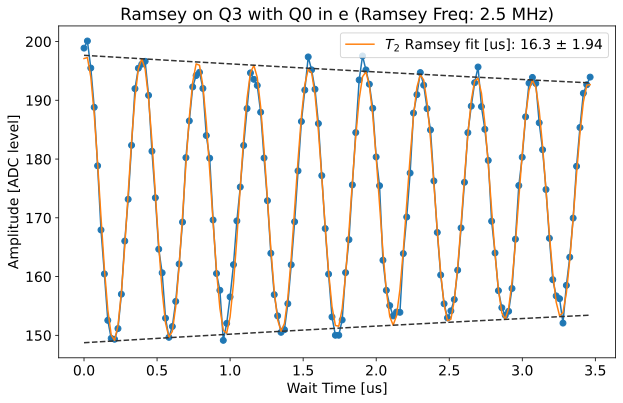

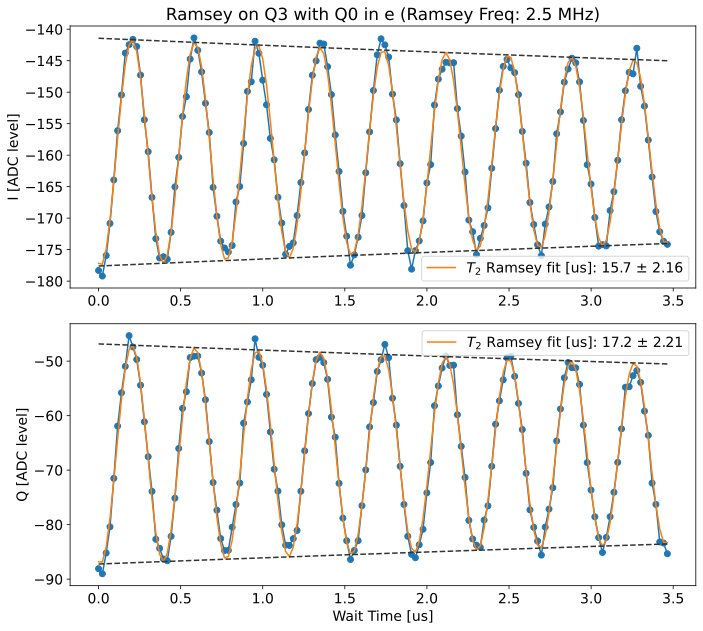

*Set Q3 shift due to Q0 in e to -0.6456740735275162*
qTest 3 qZZ 1
-------- Ramsey --------


  0%|          | 0/10 [00:00<?, ?it/s]

0
Current pi pulse frequency: 4379.754451085988
Fit frequency from amps [MHz]: 2.3922919662665656 +/- 0.0017458309212014024
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4379.862159119722
 	4374.862159119722
T2 Ramsey from fit amps [us]: 29.600041706104093
Current pi pulse frequency: 4379.754451085988
Fit frequency from I [MHz]: 2.392433837022453 +/- 0.0018909270962937635
Suggested new pi pulse frequency from fit I [MHz]:
 	4379.8620172489655
 	4374.8620172489655
T2 Ramsey from fit I [us]: 30.15662748103717
Fit frequency from Q [MHz]: 2.3919193950850706 +/- 0.0019253052602945988
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4379.862531690903
 	4374.862531690903
T2 Ramsey from fit Q [us]: 28.928334124508776


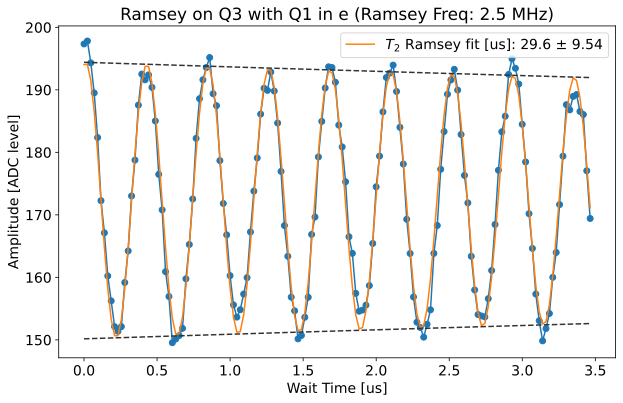

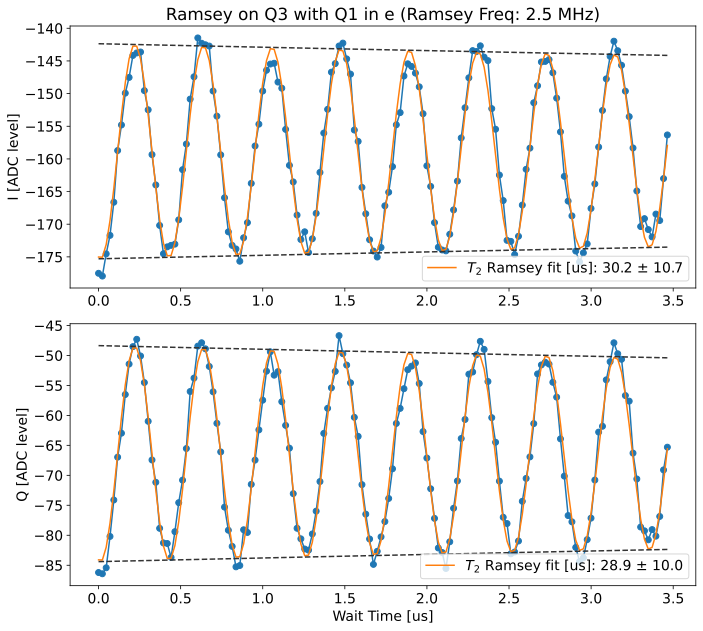

*Set Q3 shift due to Q1 in e to -1.2034424973653586*
qTest 3 qZZ 2
-------- Ramsey --------
zz shifted freqs for Q3 [4380.711552450314, 4379.930473089215, 4380.727051370314, 4381.241623620314]


  0%|          | 0/10 [00:00<?, ?it/s]

0
Current pi pulse frequency: 4380.727051370314
Fit frequency from amps [MHz]: 2.5744452108755898 +/- 0.0011963834453991983
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4380.652606159439
 	4375.652606159439
T2 Ramsey from fit amps [us]: 17.472782543498933
Current pi pulse frequency: 4380.727051370314
Fit frequency from I [MHz]: 2.5734562534194634 +/- 0.0013775819102909788
Suggested new pi pulse frequency from fit I [MHz]:
 	4380.653595116894
 	4375.653595116894
T2 Ramsey from fit I [us]: 17.913939660503292
Fit frequency from Q [MHz]: 2.5766502357283265 +/- 0.0013252818905118498
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4380.650401134586
 	4375.650401134586
T2 Ramsey from fit Q [us]: 17.291490552457567


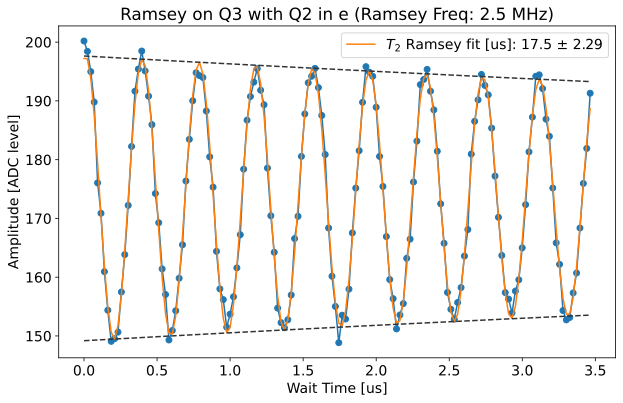

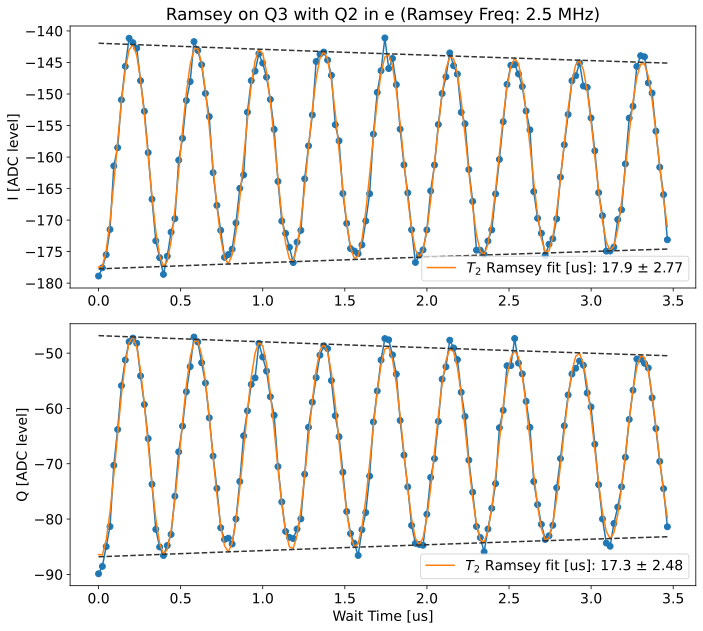

*Set Q3 shift due to Q2 in e to -0.5890174608757661*
[[ 0.         -5.24735316 -0.13680587 -0.56363367]
 [-5.27453398  0.         -1.08693169 -1.32406066]
 [-0.19332997 -1.15076088  0.         -0.56578751]
 [-0.64567407 -1.2034425  -0.58901746  0.        ]]


In [83]:
for qTest in range(4): # qubit to measure
    # for qZZ in range(4): # qubit to pulse to e
    for qZZ in range(4): # qubit to pulse to e
        # if qTest != 1: continue # UNCOMMENT IF JUST GETTING FREQS FOR Q1 ZZ
        if qZZ == qTest: continue
        print('qTest', qTest, 'qZZ', qZZ)

        # qZZspec = meas.PulseProbeCouplingSpectroscopyExperiment(
        #     soccfg=soc,
        #     path=expt_path,
        #     prefix=f"qubit_coupling_spectroscopy_qubit{qTest}{qZZ}",
        #     config_file=config_path,
        # )
        
        # span = 15
        # npts = 251
        
        # qZZspec.cfg.expt = dict(
        #     start=qZZspec.cfg.device.qubit.f_ge[qTest]-span/2, # resonator frequency to be mixed up [MHz]
        #     # start=3600,
        #     step=span/npts,
        #     expts=npts, # Number of experiments stepping from start
        #     reps=100, # Number of averages per point
        #     rounds=10, # Number of start to finish sweeps to average over
        #     pulseB=True, # Whether to apply pi pulse to qubit B
        #     length=0.2, # qubit 0 probe constant pulse length [us]
        #     gain=int(qZZspec.cfg.device.qubit.pulses.pi_ge.gain[qTest]/40), # pulse gain for qubit we are measuring
        #     pulse_type='gauss',
        #     qubits=[qTest, qZZ],
        # )
        
        # # qZZspec.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]
        
        # # print(qZZspec.cfg)
        
        # qZZspec.go(analyze=False, display=False, progress=True, save=False)

        # # ============ POST PROCESSING ============ #
        # best_signs = [1, 0, 0]
        # best_fit_err_i = np.inf
        # best_fit_err_q = np.inf
        # for sign in [1, -1]:
        #     try: 
        #         qZZspec.analyze(fit=True, signs=[1, sign, sign])
        #         fit_err_amps = qZZspec.data['fit_err_amps'][2][2]
        #         fit_err_i = qZZspec.data['fit_err_avgi'][2][2]
        #         fit_err_q = qZZspec.data['fit_err_avgq'][2][2]
        #         if fit_err_i < best_fit_err_i:
        #             best_signs[1] = sign
        #             best_fit_err_i = fit_err_i
        #         if fit_err_q < best_fit_err_q:
        #             best_signs[2] = sign
        #             best_fit_err_q = fit_err_q
        #     except: continue
        # if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
        #     qZZspec.display(fit=False)
        #     print(f'WARNING: All fits failed for Q{qTest} due to Q{qZZ} in e, please manually fix!')
        #     continue

        # qZZspec.analyze(fit=True, signs=best_signs)
        # qZZspec.display(fit=True, signs=best_signs)

        # qZZspec_fit, qZZspec_fit_err = meas.fitting.get_best_fit(qZZspec.data)
        # ZZshifts[qTest, qZZ] = qZZspec_fit[2] - qZZspec.cfg.device.qubit.f_ge[qTest]
        # print(f'Fit Q{qTest} frequency with ZZ shift [MHz]: {qZZspec_fit[2]}')
        # print(f'Q{qTest} shift due to Q{qZZ} in e [MHz]: {ZZshifts[qTest, qZZ]}')

        # yaml_cfg.device.qubit.ZZs = ZZshifts.flatten()


        print(f"-------- Ramsey --------")
        ramsey = meas.RamseyExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"ramsey_Q{qTest}_ZZ{qZZ}",
            config_file=config_path,
        )
        ramsey.cfg = AttrDict(deepcopy(yaml_cfg))
    
        ramsey.cfg.expt = dict(
            start=0, # wait time tau [us]
            step=soc.cycles2us(10), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
            # step=0.05, # [us]
            expts=151,
            # expts=151,
            ramsey_freq=2.5, # [MHz]
            reps=100,
            rounds=10,
            checkZZ=True,
            checkEF=False,
            qubits=[qZZ, qTest],
        )
    
        try:
            ramsey.go(analyze=False, display=False, progress=True, save=False)
            ramsey.analyze(fit=True)

            ramsey_fit, ramsey_fit_err, ramsey_adjust = meas.fitting.get_best_fit(ramsey.data, get_best_data_params=['f_adjust_ramsey'])

            ramsey.display(fit=True)

            ZZs = np.reshape(np.array(ramsey.cfg.device.qubit.ZZs), (4,4)) # MHz
            new_pi_freq = ramsey.cfg.device.qubit.f_ge[qTest] + ZZs[qTest, qZZ] + ramsey_adjust[0]

            ZZshifts[qTest, qZZ] = new_pi_freq - ramsey.cfg.device.qubit.f_ge[qTest]
            print(f'*Set Q{qTest} shift due to Q{qZZ} in e to {ZZshifts[qTest, qZZ]}*')

        except Exception as e:
            print(e)
            print(f'!!!!!!! RAMSEY FAILED ON QUBIT {qTest}!!!!!!!')
            continue

print(ZZshifts)

In [84]:
# ZZshifts = (ZZshifts + ZZshifts.transpose())/2
print(ZZshifts)

[[ 0.         -5.24735316 -0.13680587 -0.56363367]
 [-5.27453398  0.         -1.08693169 -1.32406066]
 [-0.19332997 -1.15076088  0.         -0.56578751]
 [-0.64567407 -1.2034425  -0.58901746  0.        ]]


In [15]:
# retrieve ZZ shifts from yaml

f_Q1_ZZ = np.array(yaml_cfg.device.qubit.f_Q1_ZZ)
f_Q_ZZ1 = np.array(yaml_cfg.device.qubit.f_Q_ZZ1)
f_ge = np.array(yaml_cfg.device.qubit.f_ge)
# # print(f_Q1_ZZ-f_ge[1])

ZZshifts[1, :] = f_Q1_ZZ - f_ge[1]
ZZshifts[:, 1] = f_Q_ZZ1 - f_ge
print(ZZshifts)
# print(f_ge[:] + ZZshifts[:, 1])

[[ 0.00000000e+00 -4.20088878e+00 -1.30170919e-01 -5.30071175e-01]
 [-5.25455623e+00 -3.45045689e+03 -1.14544477e+00 -1.35075278e+00]
 [-1.30170919e-01 -6.79935773e-01  0.00000000e+00 -5.14572251e-01]
 [-5.30071175e-01  1.32404704e+00 -5.14572251e-01  0.00000000e+00]]


In [85]:
print("UPDATE MANUALLY IN CONFIG:")
print(f'ZZs: [', end='')
print(*ZZshifts.flatten(), sep=', ', end='')
print(']')

UPDATE MANUALLY IN CONFIG:
ZZs: [0.0, -5.247353163402295, -0.13680586790724192, -0.5636336744364598, -5.274533978365071, 0.0, -1.086931693679162, -1.3240606637937162, -0.1933299734719185, -1.1507608796036948, 0.0, -0.5657875072574825, -0.6456740735275162, -1.2034424973653586, -0.5890174608757661, 0.0]


In [86]:
print("UPDATE MANUALLY IN CONFIG:")
print(f'f_Q1_ZZ: [', end='')
print(*(ZZshifts[1] + yaml_cfg.device.qubit.f_ge[1]).flatten(), sep=', ', end=']\n')
print(f'f_Q_ZZ1: [', end='')
print(*(ZZshifts[:,1] + yaml_cfg.device.qubit.f_ge[:]).flatten(), sep=', ', end=']\n')

UPDATE MANUALLY IN CONFIG:
f_Q1_ZZ: [3445.182353979969, 3450.456887958334, 3449.369956264655, 3449.13282729454]
f_Q_ZZ1: [4111.380530344018, 3450.456887958334, 4765.396198241655, 4380.038181122949]


# Get couplings by optimization

In [53]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from scipy.optimize import minimize

In [87]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [88]:
# ZZshifts = np.array([[ 0., -0.6, -0.06, 0.12],
#  [-0.5, 0., -4.3, -0.86],
#  [ -0.04, -5.0,  0., -0.21 ],
#  [ -0.25, -0.44, 0.11, 0.]]
# )

In [89]:
# gs_arr = [g01, g12, g13, g02, g03, g23]
def gs_mat_from_gs_arr(gs_arr):
    gs_matrix = np.zeros((4,4)) # first dim: qubit 0, second dim: qubit 1
    gs_matrix[0, 1] = gs_arr[0]
    gs_matrix[1, 2] = gs_arr[1]
    gs_matrix[1, 3] = gs_arr[2]
    gs_matrix[0, 2] = gs_arr[3]
    gs_matrix[0, 3] = gs_arr[4]
    gs_matrix[2, 3] = gs_arr[5]
    gs_matrix += gs_matrix.transpose()
    return gs_matrix

In [90]:
# Provide measured qubit freqs (GHz), alphas (GHz), ZZ matrix (GHz)
# For use in optimization
def ZZ_g_diff(gs, *args):
    qubit_freqs, alphas, ZZ_matrix = args
    # print(args)
    qram = QSwitch(
        EJs=None,
        ECs=None,
        gs=gs_mat_from_gs_arr(gs),
        qubit_freqs=qubit_freqs,
        alphas=alphas,
        cutoffs=[4, 5, 4, 4],
        isCavity=[False]*4,
    )
    # print(qram.get_ZZ_matrix())
    # return np.sum(np.abs(ZZ_matrix - qram.get_ZZ_matrix()))
    return np.sum(np.abs(1e3*(abs(ZZ_matrix) - abs(qram.get_ZZ_matrix())))**2)

In [91]:
ZZshifts = np.reshape(np.array(yaml_cfg.device.qubit.ZZs), (4,4)) # MHz
print(ZZshifts)

[[ 0.         -5.24735316 -0.13680587 -0.56363367]
 [-5.27453398  0.         -1.08693169 -1.32406066]
 [-0.19332997 -1.15076088  0.         -0.56578751]
 [-0.64567407 -1.2034425  -0.58901746  0.        ]]


In [92]:
x0 = np.array([50, 50, 50, 5, 5, 5])
qubit_freqs_MHz = np.array(yaml_cfg.device.qubit.f_ge) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq)
alphas_MHz = np.array(yaml_cfg.device.qubit.f_ef) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq) - qubit_freqs_MHz

print('qubit freqs', qubit_freqs_MHz)
print('alphas', alphas_MHz)
bounds = [(1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1)]

result = minimize(ZZ_g_diff, x0=1e-3*x0, args=(1e-3*qubit_freqs_MHz, 1e-3*alphas_MHz, 1e-3*ZZshifts), bounds=bounds, method='L-BFGS-B')

qubit freqs [4116.62788351 3450.45688796 4766.54695912 4381.24162362]
alphas [-226.08119024 -100.47373606 -189.86650552 -170.59881297]


In [93]:
print(f'Success: {result.success}')
gs_opt = result.x # GHz
print(f'Optimized g01, g12, g13, g02, g03, g23 [MHz]')
print('gs: [', end='')
print(*(gs_opt*1e3), sep=', ', end=']\n')

print('ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]')
print('Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)')
qram = QSwitch(
    EJs=None,
    ECs=None,
    gs=gs_mat_from_gs_arr(gs_opt),
    qubit_freqs=1e-3*qubit_freqs_MHz,
    alphas=1e-3*alphas_MHz,
    cutoffs=[4, 5, 4, 4],
    isCavity=[False]*4,
)
print('Measured ZZ matrix [MHz]')
print(ZZshifts)
print('Optimized ZZ matrix [MHz]')
print(1e3*qram.get_ZZ_matrix())
print(f'Optimization error: {ZZ_g_diff(gs_opt, 1e-3*qubit_freqs_MHz, 1e-3*alphas_MHz, 1e-3*ZZshifts)}')

Success: True
Optimized g01, g12, g13, g02, g03, g23 [MHz]
gs: [54.23041268847795, 56.142551963258384, 43.81946027750599, 5.315330877812743, 2.7355751879298005, 6.821127255138509]
ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]
Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)
Measured ZZ matrix [MHz]
[[ 0.         -5.24735316 -0.13680587 -0.56363367]
 [-5.27453398  0.         -1.08693169 -1.32406066]
 [-0.19332997 -1.15076088  0.         -0.56578751]
 [-0.64567407 -1.2034425  -0.58901746  0.        ]]
Optimized ZZ matrix [MHz]
[[ 0.         -5.26094493 -0.16507032 -0.60465237]
 [-5.26094493  0.         -1.1188442  -1.26375179]
 [-0.16507032 -1.1188442   0.         -0.57740222]
 [-0.60465237 -1.26375179 -0.57740222  0.        ]]
Optimization error: 0.014913468072906931


# ZZ shifted pi pulse calibrations for Q1 with Qx in e (pi_Q1_ZZ)

In [10]:
save_data = False
saved_files = []

In [26]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [27]:
results = dict(
    gain=[0]*4,
    sigma=[0]*4,
    f_Q1_ZZ=[0]*4,
    )

######### BEGINNING QUBIT 3 #########
q0 is 3 pi_len is 0.02
-------- Error amplification --------
{'device': {'readout': {'trig_offset': 135, 'lo_sideband': [1, -1, 1, 1], 'frequency': [-67.5604563688476, -818.3165832328616, 824.8647139155917, 93.52599999666671], 'frequency_ef': [-67.5604563688476, -818.3165832328616, 823.0647139155917, 92.22599999666672], 'gain': [0.16, 0.11, 0.4, 0.4], 'readout_length': [7.0, 5.0, 8.0, 2.5], 'relax_delay': [300, 525, 300, 350]}, 'qubit': {'f_ge': [4116.62788350742, 3450.456887958334, 4766.546959121259, 4381.241623620314], 'f_ef': [3890.5466932677664, 3349.983151894969, 4576.680453599131, 4210.642810651382], 'f_Q1_ZZ': [3445.1695202603087, 0, 3449.3409621315604, 3449.179169646872], 'f_Q_ZZ1': [4111.357154037054, 0, 4765.446645017305, 4379.754451085988], 'f_EgGf': [2686.53594683, 0, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [0, 0, 5889.630708333333, 5145.8], 'f_f0g1': [0, 1006.52, 0, 0], 'gs': [53.81744103399963, 55.95274071800953, 44.5514225071792, 

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)


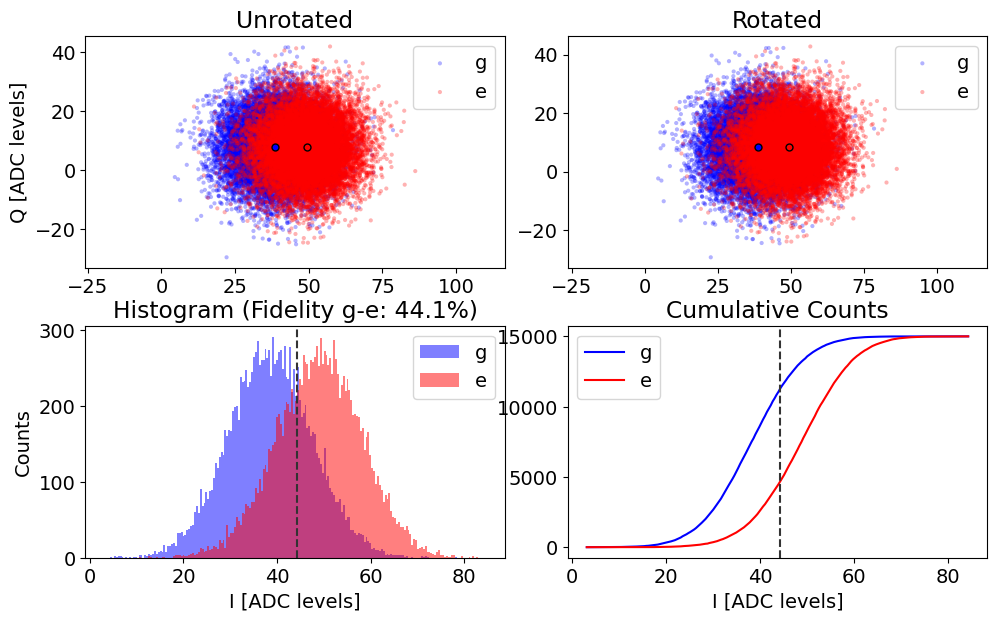

ge fidelity (%): 44.08146938231275 	 angle (deg): 0.8681577276614587 	 threshold ge: 44.267601930665066
thresholds=[0, 44.267601930665066, 0, 0],
angles=[0, 0.8681577276614587, 0, 0],
ge_avgs=[array([0., 0., 0., 0.]), [38.73024328779007, 7.877451962697896, 49.130907655606165, 7.685109303838647], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[2004, 9051, 752, 3193], [827, 3646, 1943, 8584]]


  0%|          | 0/20 [00:00<?, ?it/s]

From amps: adjust amplitude to (current gain) / 1.046840757259391


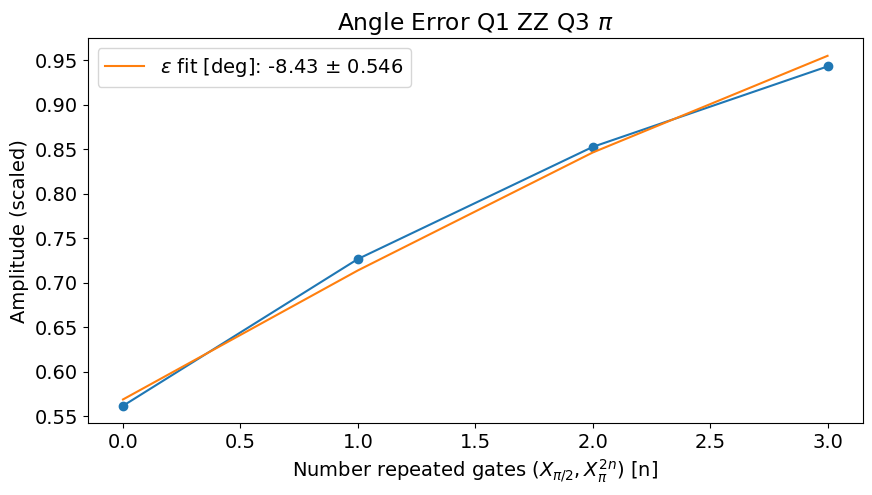

From avgi: adjust amplitude to (current gain) / 1.0465204030316864

From avgq: adjust amplitude to (current gain) / 1.0102971627989243


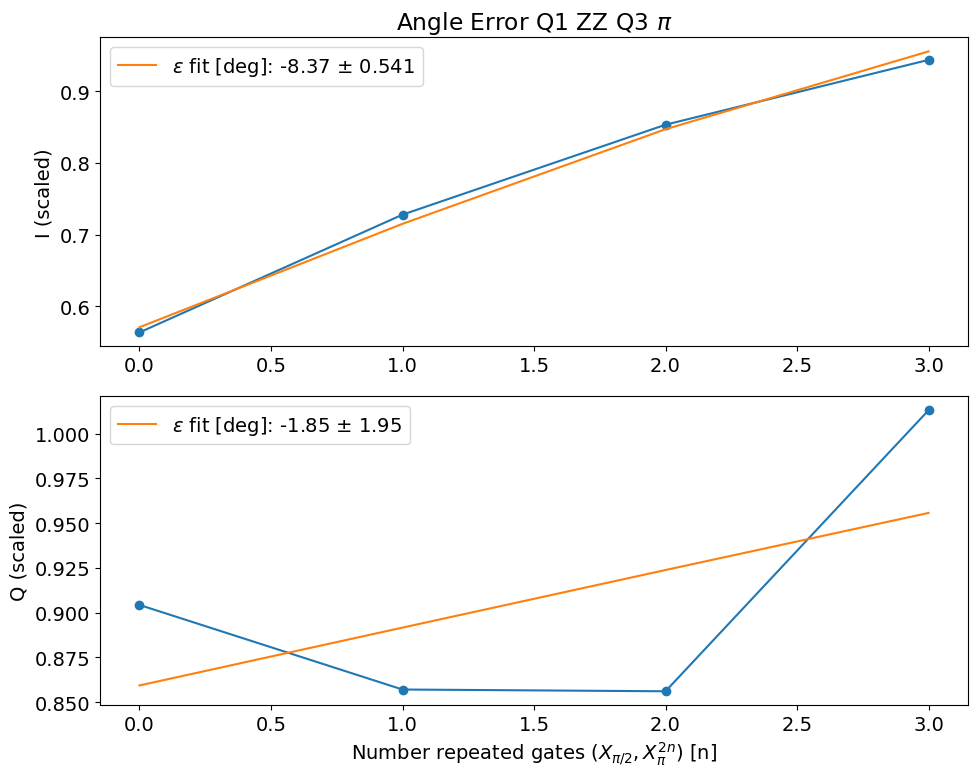

*Set Q1 pi pulse gain with Q3 in e pi_Q1_ZZ[3] to 27927*





In [28]:
try: save_data
except:
    assert False, 'you did not run the cell above!'
q1 = 1

thresholds=None
angles=None
ge_avgs=None
counts_calib=None

# for q0 in [3]:
for q0 in range(4):
    if q0 == q1: continue

    print(f"######### BEGINNING QUBIT {q0} #########")

    # print(f"-------- length rabi --------")
    # lengthrabiZZ = meas.LengthRabiExperiment(
    #     soccfg=soc,
    #     path=expt_path,
    #     prefix=f"length_rabi_ZZ_qubit{q0}{q1}",
    #     config_file=config_path,
    # )
    # lengthrabiZZ.cfg = AttrDict(deepcopy(yaml_cfg))

    # lengthrabiZZ.cfg.expt = dict(
    #     start=0, # pulse length (sigma) [us]
    #     step=soc.cycles2us(1), # [us]
    #     expts=101,
    #     reps=2000,
    #     gain=yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0],
    #     pulse_type='gauss',
    #     qubits=[q0, q1],
    #     checkZZ=True,
    #     checkEF=False, 
    # )

    # try:
    #     import Pyro4.util
    #     try:
    #         lengthrabiZZ.go(analyze=False, display=False, progress=True, save=False)
    #     except Exception:
    #         print("Pyro traceback:")
    #         print("".join(Pyro4.util.getPyroTraceback()))

    #     lengthrabiZZ.analyze(fit=True)
    
    #     lengthrabi_fit, lengthrabi_fit_err = meas.fitting.get_best_fit(lengthrabiZZ.data)
    
    #     lengthrabiZZ.display(fit=True)
    #     p = lengthrabi_fit
    #     if p[2] > 180: p[2] = p[2] - 360
    #     elif p[2] < -180: p[2] = p[2] + 360
    #     if p[2] < 0: pi_len = (1/2 - p[2]/180)/2/p[1]
    #     else: pi_len = (3/2 - p[2]/180)/2/p[1]
    #     pi_len = np.max((0.9*pi_len, 0.015)) # since we run the length rabi at a < max gain
    
    #     lengthrabi_decay = p[3]

    #     print(f'Will use sigma {pi_len} for amplitude rabi')

    #     if save_data: saved_files.append(lengthrabiZZ.save_data())

    # except Exception as e:
    #     print(e)
    #     print(f'!!!!!!! LENGTH RABI FAILED ON QUBIT {q0} !!!!!!!')
    #     continue
    
    pi_len = yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[q0]
    print('q0 is', q0, 'pi_len is', pi_len)

    # print(f"-------- Amp rabi --------")
    # amprabi = meas.AmplitudeRabiExperiment(
    #     soccfg=soc,
    #     path=expt_path,
    #     prefix=f"amp_rabi_qubit{q0}{q1}",
    #     config_file=config_path,
    # )
    # amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

    # span = min((32000, 1.5*yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0]))
    # npts = 151

    # amprabi.cfg.expt = dict(
    #     start=0, # qubit gain [dac level]
    #     step=int(span/npts), # [dac level]
    #     expts=npts,
    #     reps=100,
    #     rounds=10,
    #     sigma_test=pi_len, # gaussian sigma for pulse length - overrides config [us]
    #     pulse_type='gauss',
    #     checkZZ=True,
    #     checkEF=False, 
    #     qubits=[q0, q1],
    # )
    # try:
    #     import Pyro4.util
    #     try:
    #         amprabi.go(analyze=False, display=False, progress=True, save=False)
    #     except Exception:
    #         print("Pyro traceback:")
    #         print("".join(Pyro4.util.getPyroTraceback()))

    #     amprabi.analyze(fit=True)

    #     amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data)

    #     p = amprabi_fit
    #     if p[2] > 180: p[2] = p[2] - 360
    #     elif p[2] < -180: p[2] = p[2] + 360
    #     if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
    #     else: pi_gain = (3/2 - p[2]/180)/2/p[1]

    #     if pi_gain > 32000:
    #         amprabi.display(fit=False)
    #         print('WARNING: Fit pi pulse gain is long, please double check!')
    #         pi_gain = 30000
    #     else: amprabi.display(fit=True)
    #     yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[q0] = amprabi.cfg.expt.sigma_test

    #     yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[q0] = pi_len
    #     results['sigma'][q0] =  pi_len
    #     print(f'*Set Q1 pi pulse sigma with Q{q0} in e to {yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[q0]}*')

    #     yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0] = int(pi_gain)
    #     results['gain'][q0] =  int(pi_gain)
    #     print(f'*Set Q1 pi pulse gain with Q{q0} in e to {yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0]}*')

    #     if save_data: saved_files.append(amprabi.save_data())

    # except Exception as e:
    #     print(e)
    #     print(f'!!!!!!! AMP RABI FAILED ON QUBIT {q0} !!!!!!!')
    #     continue

    # print(f"-------- Ramsey --------")
    # ramsey = meas.RamseyExperiment(
    #     soccfg=soc,
    #     path=expt_path,
    #     prefix=f"ramsey_qubit{q1}",
    #     config_file=config_path,
    # )
    # ramsey.cfg = AttrDict(deepcopy(yaml_cfg))
    
    # ramsey.cfg.expt = dict(
    #     start=0, # wait time tau [us]
    #     step=soc.cycles2us(10), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    #     # step=0.05, # [us]
    #     expts=151,
    #     # expts=151,
    #     ramsey_freq=2.5, # [MHz]
    #     reps=100,
    #     rounds=10,
    #     checkZZ=True,
    #     checkEF=False,
    #     qubits=[q0, q1],
    # )
    
    # try:
    #     ramsey.go(analyze=False, display=False, progress=True, save=False)
    #     ramsey.analyze(fit=True)

    #     ramsey_fit, ramsey_fit_err, ramsey_adjust = meas.fitting.get_best_fit(ramsey.data, get_best_data_params=['f_adjust_ramsey'])

    #     ramsey.display(fit=True)
    #     new_pi_freq = ramsey.cfg.device.qubit.f_Q1_ZZ[q0] + ramsey_adjust[0]
    #     yaml_cfg.device.qubit.f_Q1_ZZ[q0] = new_pi_freq
    #     print(f'*Set Q1 pi pulse freq with Q{q0} in e to {yaml_cfg.device.qubit.f_Q1_ZZ[q0]}*')
    #     results['f_Q1_ZZ'][q0] =  new_pi_freq

    #     if save_data: saved_files.append(ramsey.save_data())

    # except Exception as e:
    #     print(e)
    #     print(f'!!!!!!! RAMSEY FAILED ON QUBIT {q0}!!!!!!!')
    #     continue


    # print(f"-------- Amp rabi round 2 --------")
    # amprabi = meas.AmplitudeRabiExperiment(
    #     soccfg=soc,
    #     path=expt_path,
    #     prefix=f"amp_rabi_qubit{q0}{q1}",
    #     config_file=config_path,
    # )
    # amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

    # n_pulses = 1
    # span = min((32000, 1.5*yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0]/n_pulses))
    # npts = 151

    # amprabi.cfg.expt = dict(
    #     start=0, # qubit gain [dac level]
    #     step=int(span/npts), # [dac level]
    #     expts=npts,
    #     reps=100,
    #     rounds=10,
    #     sigma_test=pi_len, # gaussian sigma for pulse length - overrides config [us]
    #     pulse_type='gauss',
    #     checkZZ=True,
    #     checkEF=False, 
    #     n_pulses=n_pulses,
    #     qubits=[q0, q1],
    # )
    # try:
    #     import Pyro4.util
    #     try:
    #         amprabi.go(analyze=False, display=False, progress=True, save=False)
    #     except Exception:
    #         print("Pyro traceback:")
    #         print("".join(Pyro4.util.getPyroTraceback()))

    #     amprabi.analyze(fit=True)

    #     amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data)

    #     p = amprabi_fit
    #     if p[2] > 180: p[2] = p[2] - 360
    #     elif p[2] < -180: p[2] = p[2] + 360
    #     if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
    #     else: pi_gain = (3/2 - p[2]/180)/2/p[1]

    #     if pi_gain > 32000:
    #         amprabi.display(fit=False)
    #         print('WARNING: Fit pi pulse gain is long, please double check!')
    #         pi_gain = 30000
    #     else: amprabi.display(fit=True)
    #     yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[q0] = amprabi.cfg.expt.sigma_test

    #     yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[q0] = pi_len
    #     results['sigma'][q0] =  pi_len
    #     print(f'*Set Q1 pi pulse sigma with Q{q0} in e pi_Q1_ZZ[{q0}] to {yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[q0]}*')

    #     yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0] = int(pi_gain*n_pulses)
    #     results['gain'][q0] =  int(pi_gain*n_pulses)
    #     print(f'*Set Q1 pi pulse gain with Q{q0} in e pi_Q1_ZZ[{q0}] to {yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0]}*')

    #     if save_data: saved_files.append(amprabi.save_data())

    # except Exception as e:
    #     print(e)
    #     print(f'!!!!!!! AMP RABI FAILED ON QUBIT {q0} !!!!!!!')
    #     continue

    print(f"-------- Error amplification --------")

    npulsecalib = meas.NPulseExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"NPulseExptQ{q0}{q1}",
        config_file=config_path,
    )

    npulsecalib.cfg = AttrDict(deepcopy(yaml_cfg))
    npulsecalib.cfg.expt = dict(
        start=0, # number gate repetitions
        step=1,
        expts=4,
        reps=2000,
        loops=20,
        pulse_type='gauss',
        checkZZ=True,
        checkEF=False, 
        qubits=[q0, q1],
        test_pi_half=False,

        post_process=True,
        singleshot_reps=15000,
        thresholds=thresholds,
        angles=angles,
        ge_avgs=ge_avgs,
        counts_calib=counts_calib,
    )

    print(npulsecalib.cfg)
    import Pyro4.util
    try:
        npulsecalib.go(analyze=False, display=False, progress=True, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    data = npulsecalib.data

    if thresholds is None:
        thresholds = data['thresholds']
        angles = data['angles']
        ge_avgs = data['ge_avgs']
        counts_calib = data['counts_calib']

    npulsecalib.analyze(fit=True, scale=data['ge_avgs'])
    npulsecalib.display(fit=True, scale=data['ge_avgs'])
    
    npulsecalib_fit, npulsecalib_fit_err = meas.fitting.get_best_fit(npulsecalib.data)
    
    angle_err = npulsecalib_fit[1]
    amp_ratio = (180 - angle_err) / 180
    pi_gain = npulsecalib.cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0] / amp_ratio
    
    yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0] = int(round(pi_gain))
    results['gain'][q0] = yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0]
    print(f'*Set Q1 pi pulse gain with Q{q0} in e pi_Q1_ZZ[{q0}] to {yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0]}*')

    
    print("\n\n")

In [31]:
print('pi_Q1_ZZ')
print(results)
for saved_file in saved_files:
    print(saved_file)

pi_Q1_ZZ
{'gain': [72615, 0, 89005, 87678], 'sigma': [0.025, 0, 0.02, 0.02], 'f_Q1_ZZ': [3445.1849181153643, 0, 3449.3659388054953, 3449.167602826072]}


# ZZ shifted pi pulse calibrations for Qx with Q1 in e (pi_Q_ZZ1)

In [32]:
print("UPDATE MANUALLY IN CONFIG:")
print(f'f_Q_ZZ1: [', end='')
print(*(ZZshifts[1] + yaml_cfg.device.qubit.f_ge[:]).flatten(), sep=', ', end=']\n')

UPDATE MANUALLY IN CONFIG:
f_Q_ZZ1: [4111.347378915614, 0.0, 4765.401514352141, 4379.7148488342145]


In [30]:
save_data = True
saved_files = []

In [31]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [32]:
results = dict(
    gain=[0]*4,
    sigma=[0]*4,
    f_Q_ZZ1=[0]*4,
    )

######### BEGINNING QUBIT 0 #########
-------- Ramsey --------
readout freq [-67.5604563688476, -818.3165832328616, 824.8647139155917, 93.52599999666671]


  0%|          | 0/10 [00:00<?, ?it/s]

p_amps [ 4.90239843  3.00096204 87.78878219 16.35088426 44.39671577]
ps amps 44.39671576749286 4.902398433373898 16.350884257481727
Current pi pulse frequency: 4111.347587415927
Fit frequency from amps [MHz]: 3.000962039296272 +/- 0.0017588870827276023
Suggested new pi pulse frequencies from fit amps [MHz]:
 	-0.0009620392962719215
 	-6.000962039296272
T2 Ramsey from fit amps [us]: 16.350884257481727
Current pi pulse frequency: 4111.347587415927
Fit frequency from I [MHz]: 3.001330648108298 +/- 0.0030444384135934082
Suggested new pi pulse frequency from fit I [MHz]:
 	4111.346256767818
 	4105.346256767818
T2 Ramsey from fit I [us]: 16.878001424087124
Fit frequency from Q [MHz]: 3.0009016294431525 +/- 0.0018011468195894182
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4111.346685786483
 	4105.346685786483
T2 Ramsey from fit Q [us]: 16.199414913994318


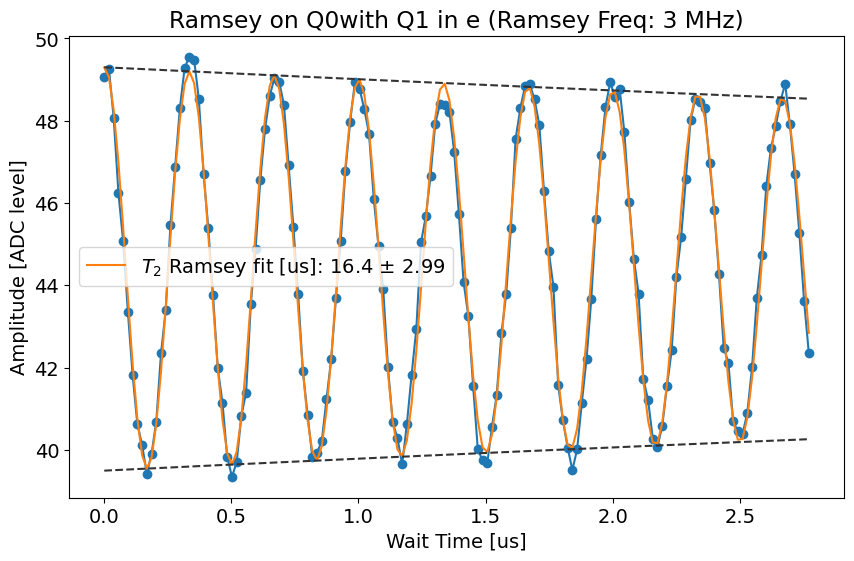

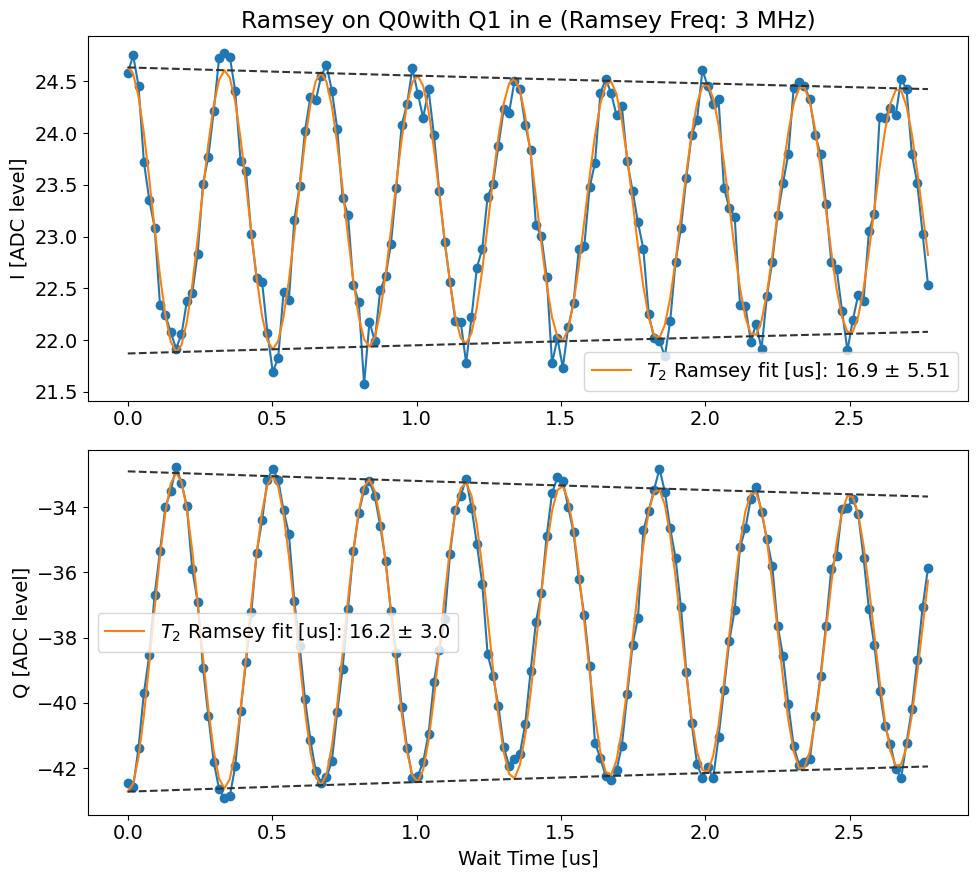

*Set Q0 pi pulse freq with Q1 in e to 4111.34662537663*
Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00007_ramsey_qubit10.h5
-------- Amp rabi round 2 --------


  0%|          | 0/10 [00:00<?, ?it/s]

3.3003300330033e-05
Pi gain from amps data [dac units]: 20588
	Pi/2 gain from amps data [dac units]: 10294
Pi gain from avgi data [dac units]: 20664
	Pi/2 gain from avgi data [dac units]: 10332
Pi gain from avgq data [dac units]: 20583
	Pi/2 gain from avgq data [dac units]: 10291


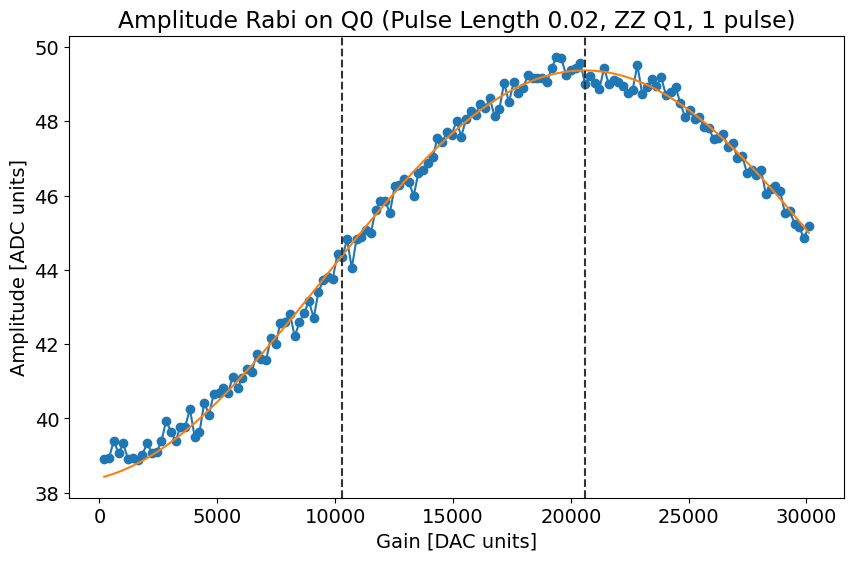

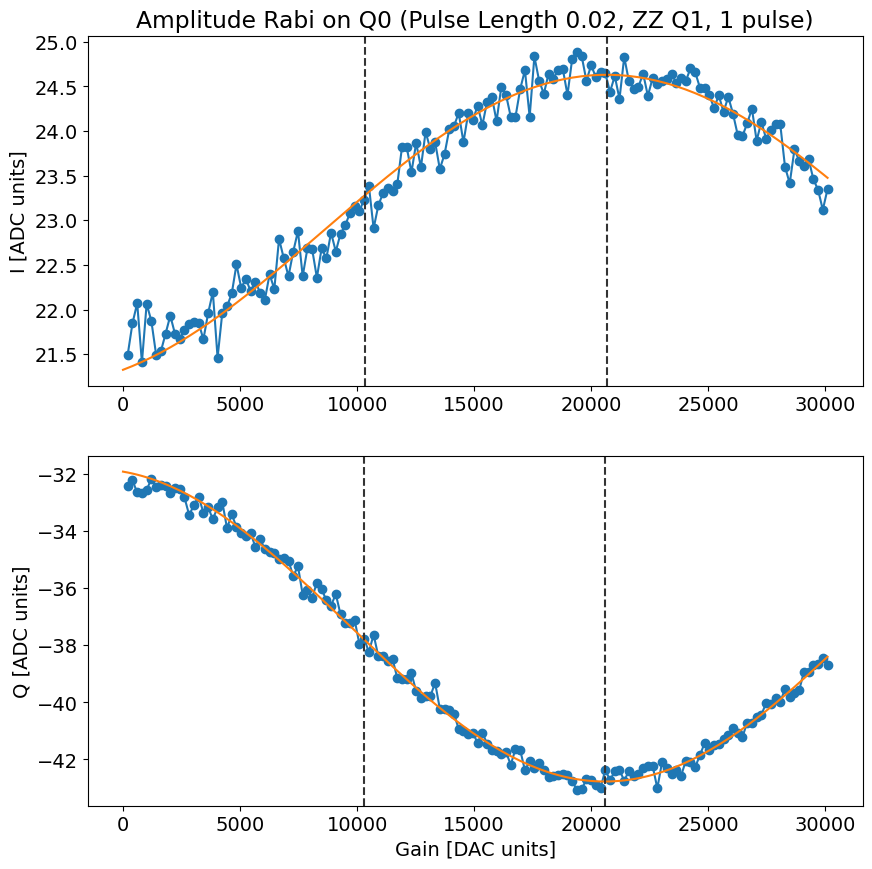

*Set Q0 pi pulse gain with Q1 in e to 20583*
Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00012_amp_rabi_qubit10.h5
-------- Error amplification --------
{'device': {'readout': {'trig_offset': 135, 'lo_sideband': [1, -1, 1, 1], 'frequency': [-67.5604563688476, -818.3165832328616, 824.8647139155917, 93.52599999666671], 'frequency_ef': [-67.5604563688476, -818.3165832328616, 823.0647139155917, 92.22599999666672], 'gain': [0.16, 0.11, 0.4, 0.4], 'readout_length': [7.0, 5.0, 8.0, 2.5], 'relax_delay': [300, 525, 300, 350]}, 'qubit': {'f_ge': [4116.62788350742, 3450.456887958334, 4766.546959121259, 4381.241623620314], 'f_ef': [3890.5466932677664, 3349.983151894969, 4576.680453599131, 4210.642810651382], 'f_Q1_ZZ': [3445.1695202603087, 0, 3449.3409621315604, 3449.179169646872], 'f_Q_ZZ1': [4111.34662537663, 0, 4765.446645017305, 4379.754451085988], 'f_EgGf': [2686.53594683, 0, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [0, 0, 5889.630708333333, 5145.8], 'f_f0g1': [0, 1006.52, 0, 

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (0)


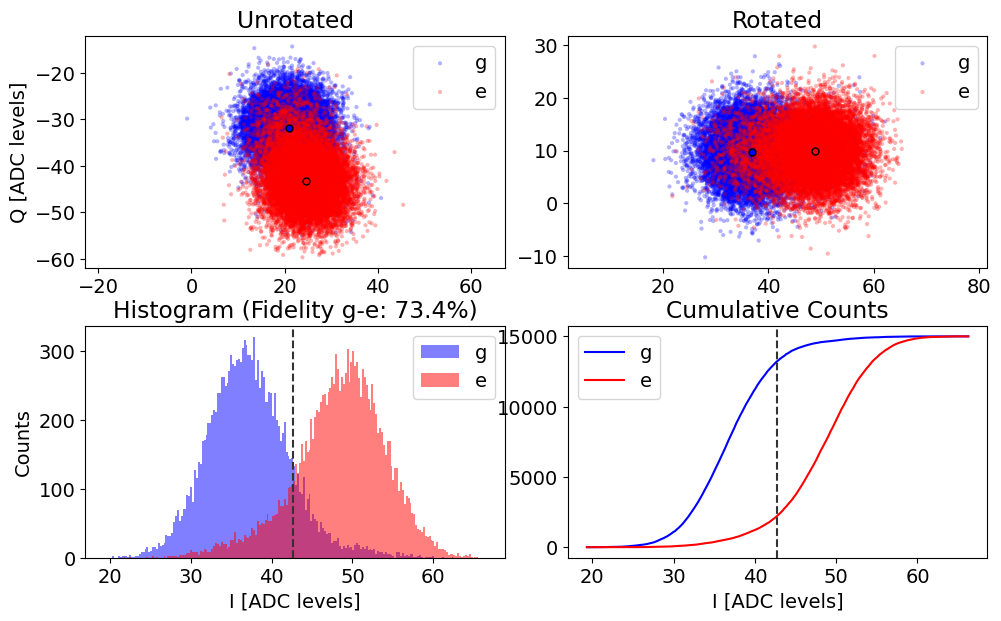

ge fidelity (%): 73.42911430381012 	 angle (deg): 71.70197788981827 	 threshold ge: 42.676492068862174
thresholds=[42.676492068862174, 0, 0, 0],
angles=[71.70197788981827, 0, 0, 0],
ge_avgs=[[20.910023461955678, -32.27583096234309, 24.651973283743995, -42.88883542538354], array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[10604, 2466, 1599, 331], [1761, 315, 11137, 1787]]


  0%|          | 0/20 [00:00<?, ?it/s]

From amps: adjust amplitude to (current gain) / 1.0335609513670594


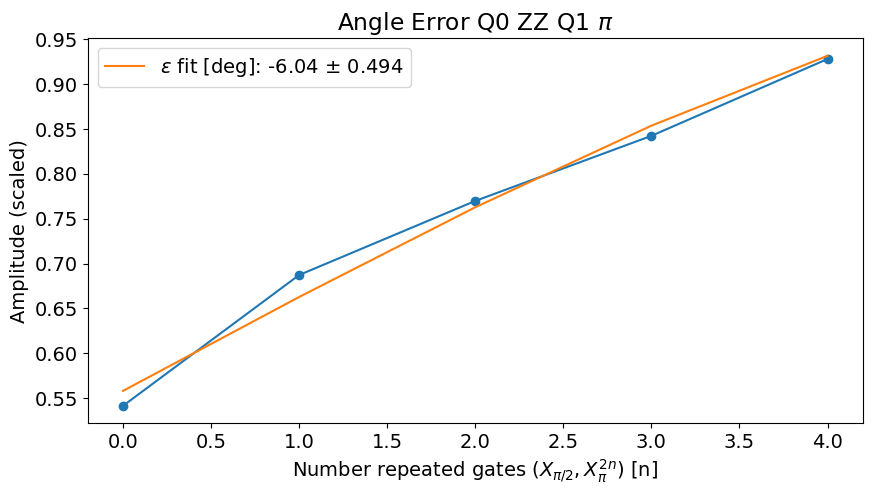

From avgi: adjust amplitude to (current gain) / 1.0266751133958387

From avgq: adjust amplitude to (current gain) / 1.0351825370494452


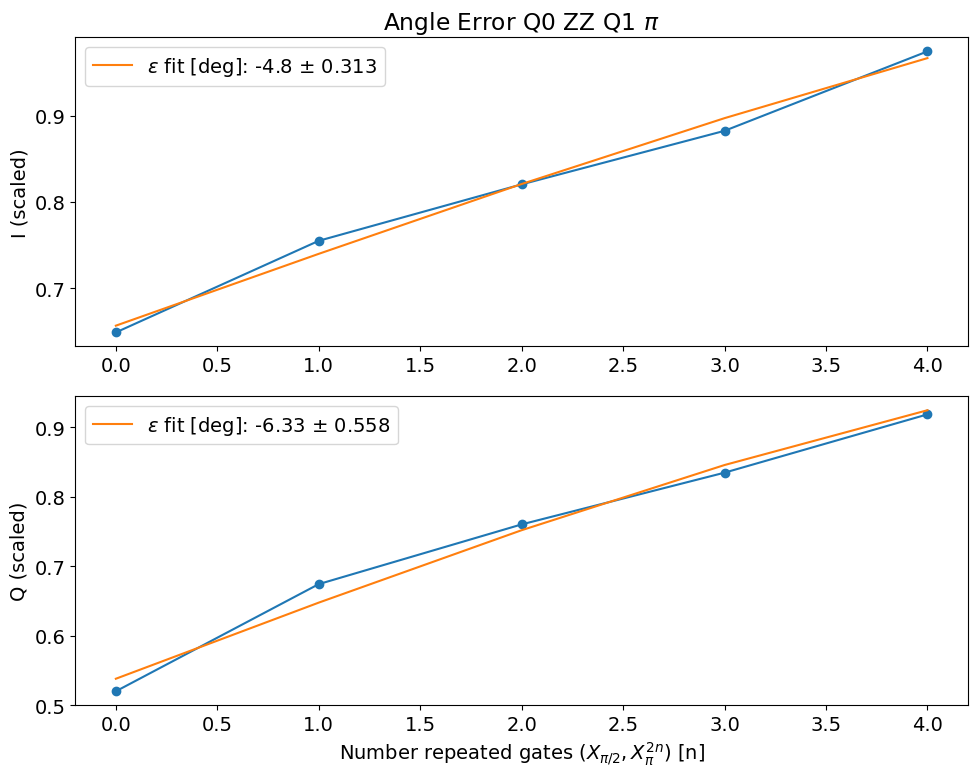

*Set Q0 pi pulse gain with Q1 in e pi_Q_ZZ1[0] to 20048*



######### BEGINNING QUBIT 2 #########
-------- Ramsey --------
readout freq [-67.5604563688476, -818.3165832328616, 824.8647139155917, 93.52599999666671]


  0%|          | 0/10 [00:00<?, ?it/s]

p_amps [ 3.17568057  3.01963803 78.41886012 20.60169206 10.11271837]
ps amps 10.112718365453073 3.1756805748413677 20.601692057249277
Current pi pulse frequency: 4765.446645017305
Fit frequency from amps [MHz]: 3.019638028637505 +/- 0.0023501591533721996
Suggested new pi pulse frequencies from fit amps [MHz]:
 	-0.019638028637504856
 	-6.019638028637505
T2 Ramsey from fit amps [us]: 20.601692057249277
Current pi pulse frequency: 4765.446645017305
Fit frequency from I [MHz]: 3.022500504503388 +/- 0.002763726999442426
Suggested new pi pulse frequency from fit I [MHz]:
 	4765.424144512802
 	4759.424144512802
T2 Ramsey from fit I [us]: 24.15729611379388
Fit frequency from Q [MHz]: 3.016516146162352 +/- 0.0025781138285631525
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4765.430128871142
 	4759.430128871142
T2 Ramsey from fit Q [us]: 17.811435742504347


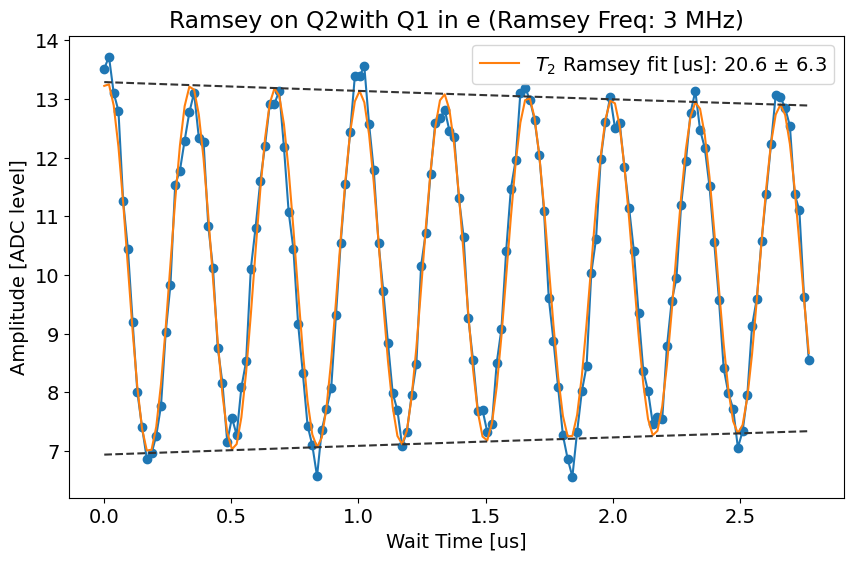

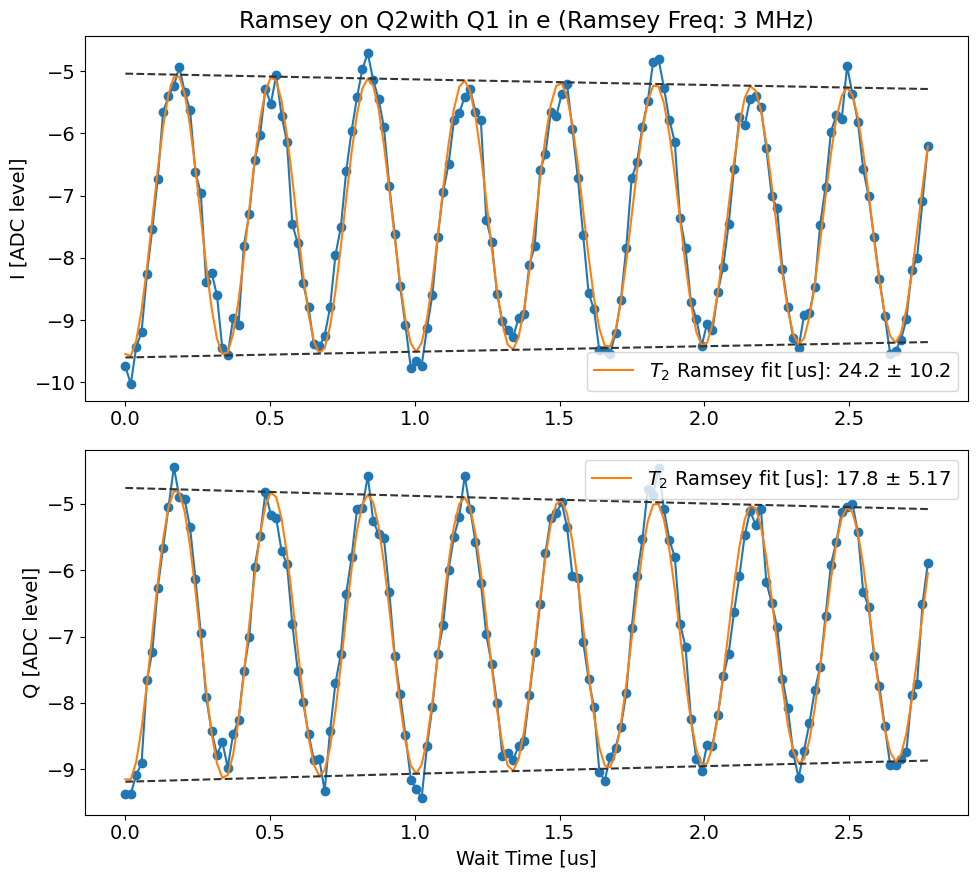

*Set Q2 pi pulse freq with Q1 in e to 4765.430128871142*
Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00002_ramsey_qubit12.h5
-------- Amp rabi round 2 --------


  0%|          | 0/10 [00:00<?, ?it/s]

5.747126436781609e-05
Pi gain from amps data [dac units]: 11535
	Pi/2 gain from amps data [dac units]: 5767
Pi gain from avgi data [dac units]: 11532
	Pi/2 gain from avgi data [dac units]: 5766
Pi gain from avgq data [dac units]: 11538
	Pi/2 gain from avgq data [dac units]: 5769


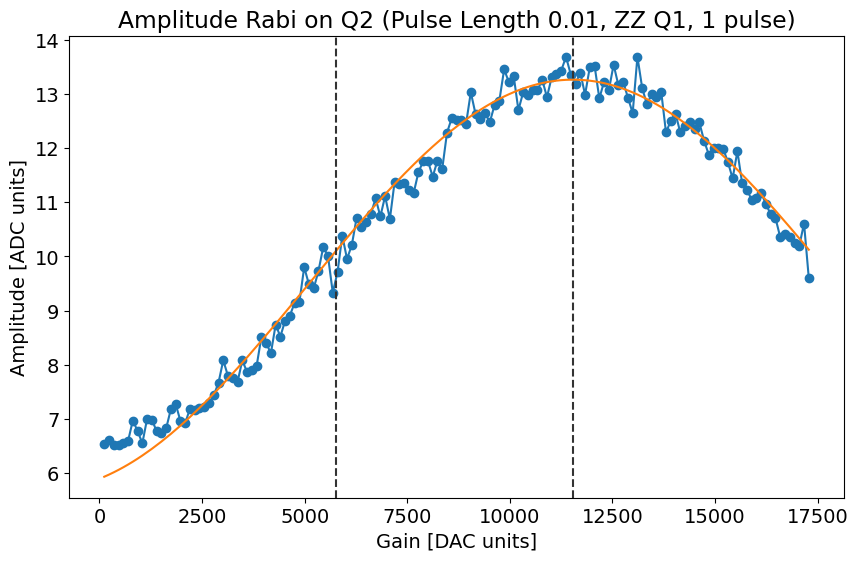

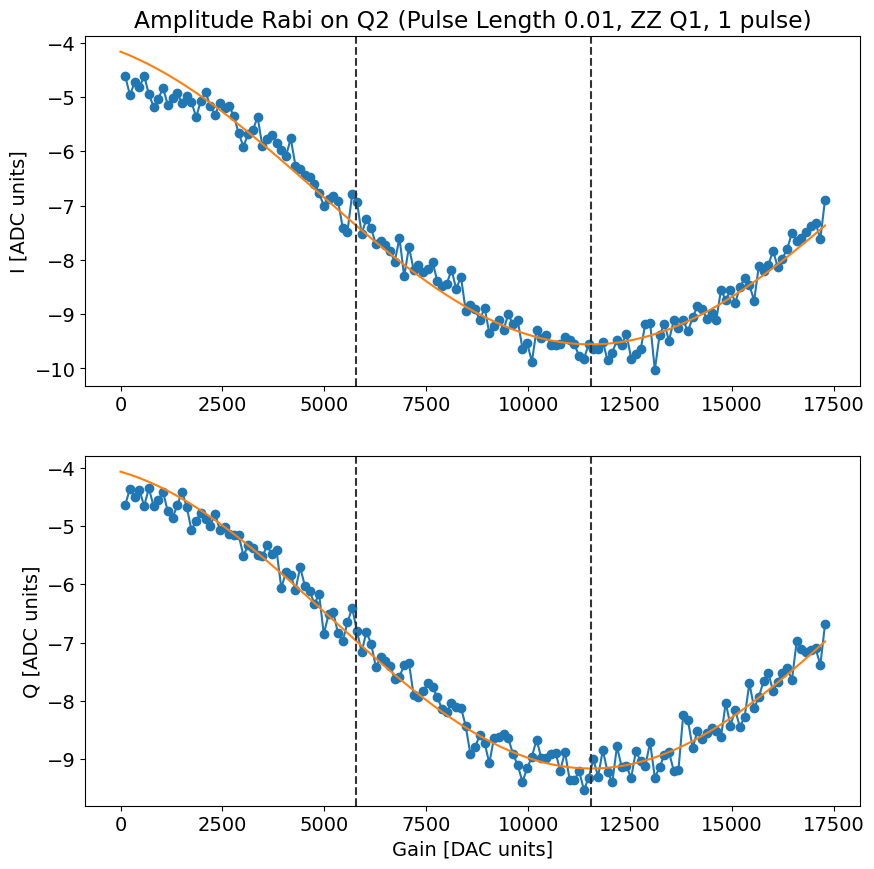

*Set Q2 pi pulse gain with Q1 in e to 11535*
Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00004_amp_rabi_qubit12.h5
-------- Error amplification --------
{'device': {'readout': {'trig_offset': 135, 'lo_sideband': [1, -1, 1, 1], 'frequency': [-67.5604563688476, -818.3165832328616, 824.8647139155917, 93.52599999666671], 'frequency_ef': [-67.5604563688476, -818.3165832328616, 823.0647139155917, 92.22599999666672], 'gain': [0.16, 0.11, 0.4, 0.4], 'readout_length': [7.0, 5.0, 8.0, 2.5], 'relax_delay': [300, 525, 300, 350]}, 'qubit': {'f_ge': [4116.62788350742, 3450.456887958334, 4766.546959121259, 4381.241623620314], 'f_ef': [3890.5466932677664, 3349.983151894969, 4576.680453599131, 4210.642810651382], 'f_Q1_ZZ': [3445.1695202603087, 0, 3449.3409621315604, 3449.179169646872], 'f_Q_ZZ1': [4111.34662537663, 0, 4765.430128871142, 4379.754451085988], 'f_EgGf': [2686.53594683, 0, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [0, 0, 5889.630708333333, 5145.8], 'f_f0g1': [0, 1006.52, 0, 

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (2)


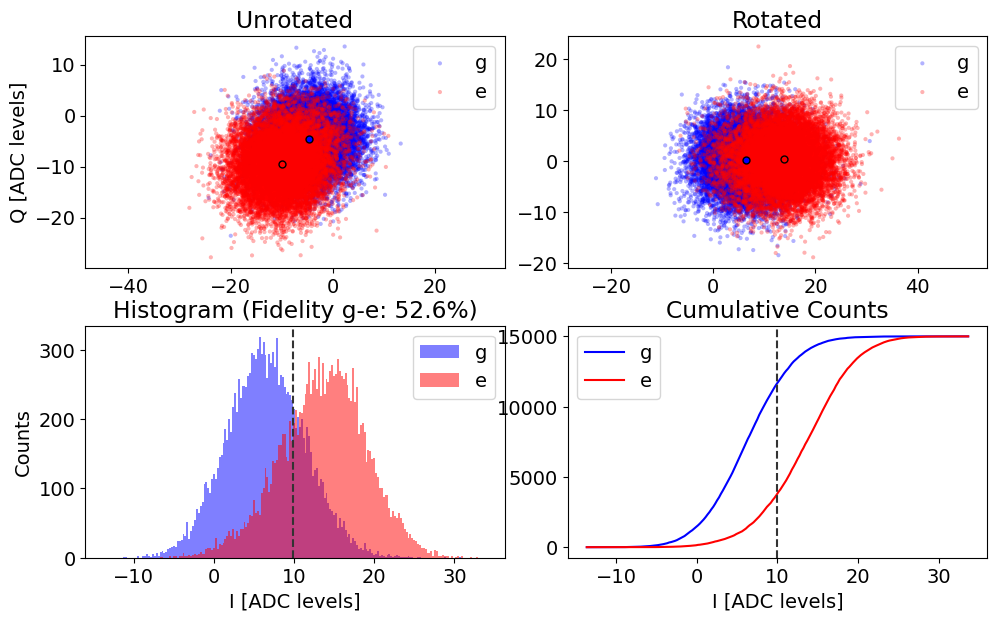

ge fidelity (%): 52.55683712247483 	 angle (deg): 137.6089246830492 	 threshold ge: 9.901012934194773
thresholds=[0, 0, 9.901012934194773, 0],
angles=[0, 0, 137.6089246830492, 0],
ge_avgs=[array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), [-4.670334661786635, -4.551758492612173, -9.880953124576385, -9.422571180696758], array([0., 0., 0., 0.])],
counts_calib=[[0, 11384, 0, 3616], [0, 3521, 1, 11478]]


  0%|          | 0/20 [00:00<?, ?it/s]

From amps: adjust amplitude to (current gain) / 0.9915664831912575


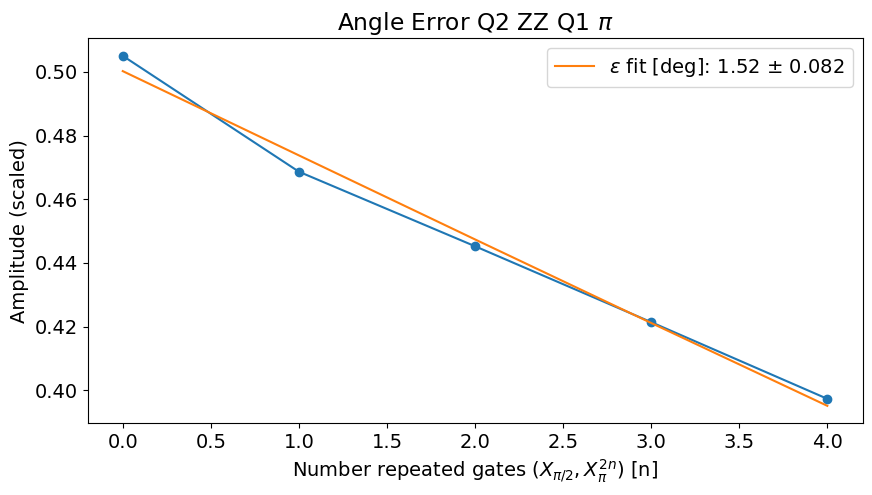

From avgi: adjust amplitude to (current gain) / 0.9921660648396402

From avgq: adjust amplitude to (current gain) / 0.9908899323969897


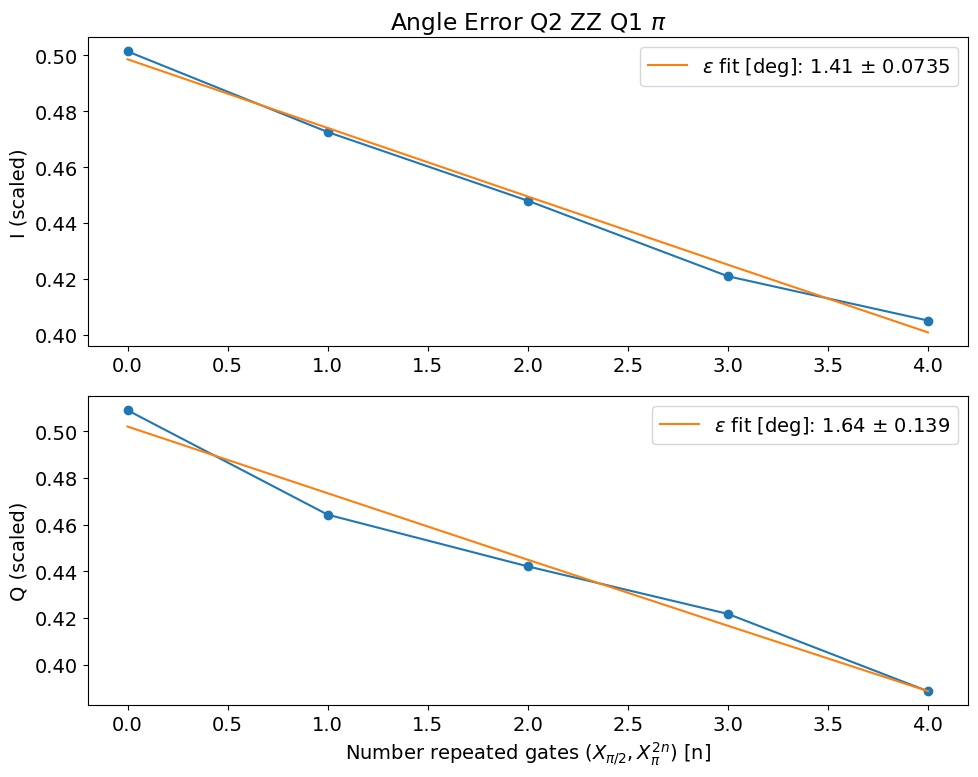

*Set Q2 pi pulse gain with Q1 in e pi_Q_ZZ1[2] to 11626*



######### BEGINNING QUBIT 3 #########
-------- Ramsey --------
readout freq [-67.5604563688476, -818.3165832328616, 824.8647139155917, 93.52599999666671]


  0%|          | 0/10 [00:00<?, ?it/s]

p_amps [ 3.99209388  2.79729075 75.65587461 12.06869951 32.4002367 ]
ps amps 32.40023669667636 3.992093878765309 12.068699508595149
Current pi pulse frequency: 4379.754451085988
Fit frequency from amps [MHz]: 2.7972907467558237 +/- 0.0021236599768734233
Suggested new pi pulse frequencies from fit amps [MHz]:
 	0.20270925324417632
 	-5.797290746755824
T2 Ramsey from fit amps [us]: 12.068699508595149
Current pi pulse frequency: 4379.754451085988
Fit frequency from I [MHz]: 2.793347271667611 +/- 0.0034805452265202607
Suggested new pi pulse frequency from fit I [MHz]:
 	4379.96110381432
 	4373.96110381432
T2 Ramsey from fit I [us]: 10.02238155670678
Fit frequency from Q [MHz]: 2.797433864731424 +/- 0.002127097319073711
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4379.957017221256
 	4373.957017221256
T2 Ramsey from fit Q [us]: 12.15486114492192


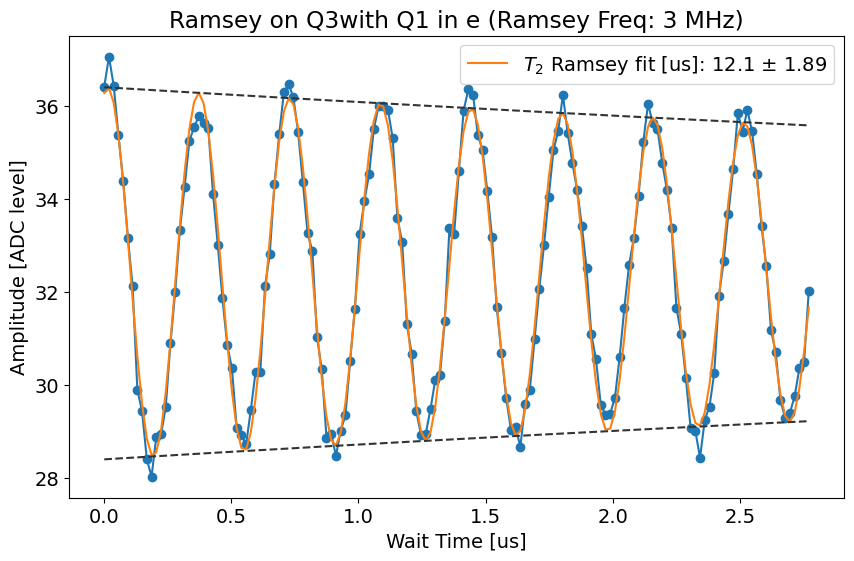

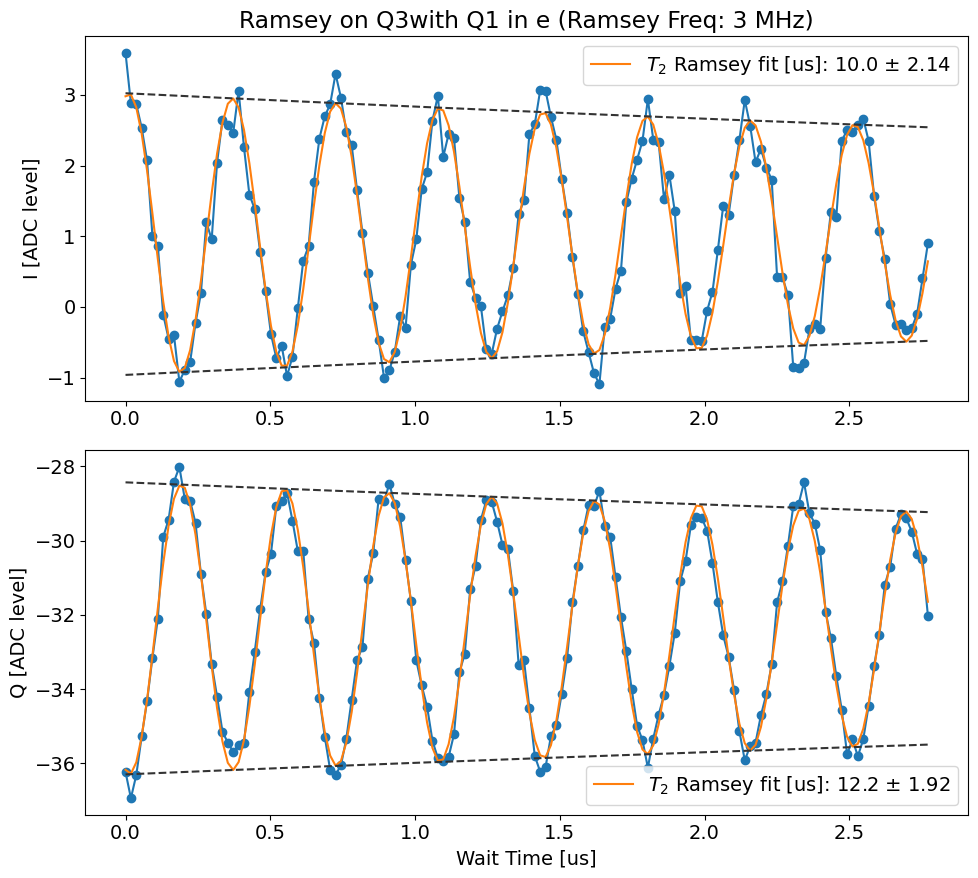

*Set Q3 pi pulse freq with Q1 in e to 4379.957017221256*
Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00003_ramsey_qubit13.h5
-------- Amp rabi round 2 --------


  0%|          | 0/10 [00:00<?, ?it/s]

0.00017543859649122806
Pi gain from amps data [dac units]: 3798
	Pi/2 gain from amps data [dac units]: 1899
Pi gain from avgi data [dac units]: 3810
	Pi/2 gain from avgi data [dac units]: 1905
Pi gain from avgq data [dac units]: 3799
	Pi/2 gain from avgq data [dac units]: 1899


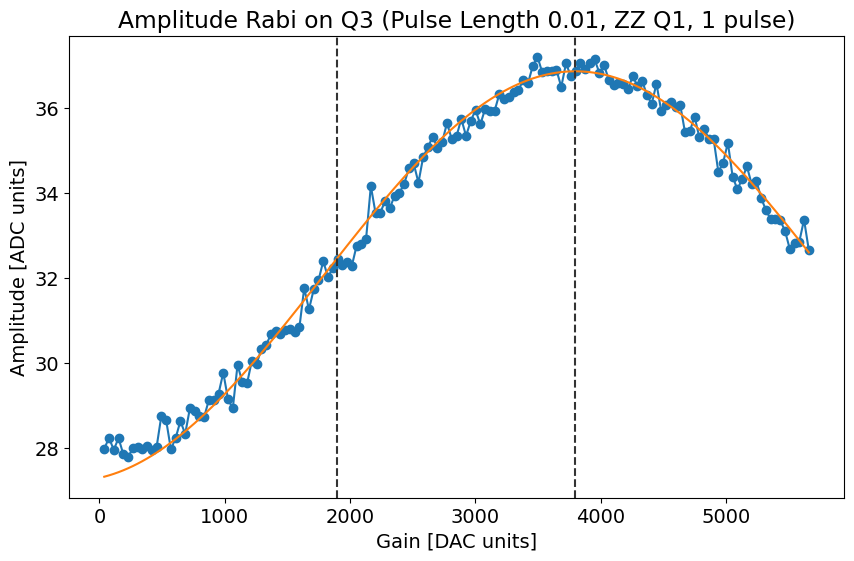

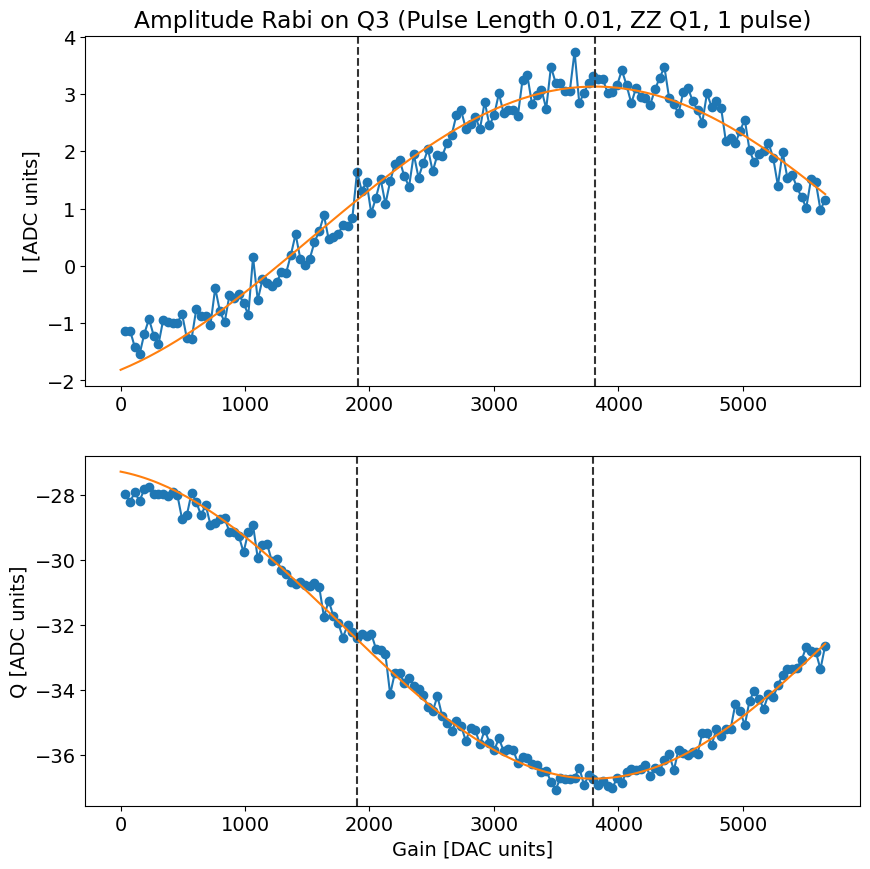

*Set Q3 pi pulse gain with Q1 in e to 3798*
Saving s:\Connie\experiments\qramLL_4QR2\data\data_240218\00006_amp_rabi_qubit13.h5
-------- Error amplification --------
{'device': {'readout': {'trig_offset': 135, 'lo_sideband': [1, -1, 1, 1], 'frequency': [-67.5604563688476, -818.3165832328616, 824.8647139155917, 93.52599999666671], 'frequency_ef': [-67.5604563688476, -818.3165832328616, 823.0647139155917, 92.22599999666672], 'gain': [0.16, 0.11, 0.4, 0.4], 'readout_length': [7.0, 5.0, 8.0, 2.5], 'relax_delay': [300, 525, 300, 350]}, 'qubit': {'f_ge': [4116.62788350742, 3450.456887958334, 4766.546959121259, 4381.241623620314], 'f_ef': [3890.5466932677664, 3349.983151894969, 4576.680453599131, 4210.642810651382], 'f_Q1_ZZ': [3445.1695202603087, 0, 3449.3409621315604, 3449.179169646872], 'f_Q_ZZ1': [4111.34662537663, 0, 4765.430128871142, 4379.957017221256], 'f_EgGf': [2686.53594683, 0, 2033.76008793, 2414.92850999], 'f_EgGf_Q': [0, 0, 5889.630708333333, 5145.8], 'f_f0g1': [0, 1006.52, 0, 0

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (3)


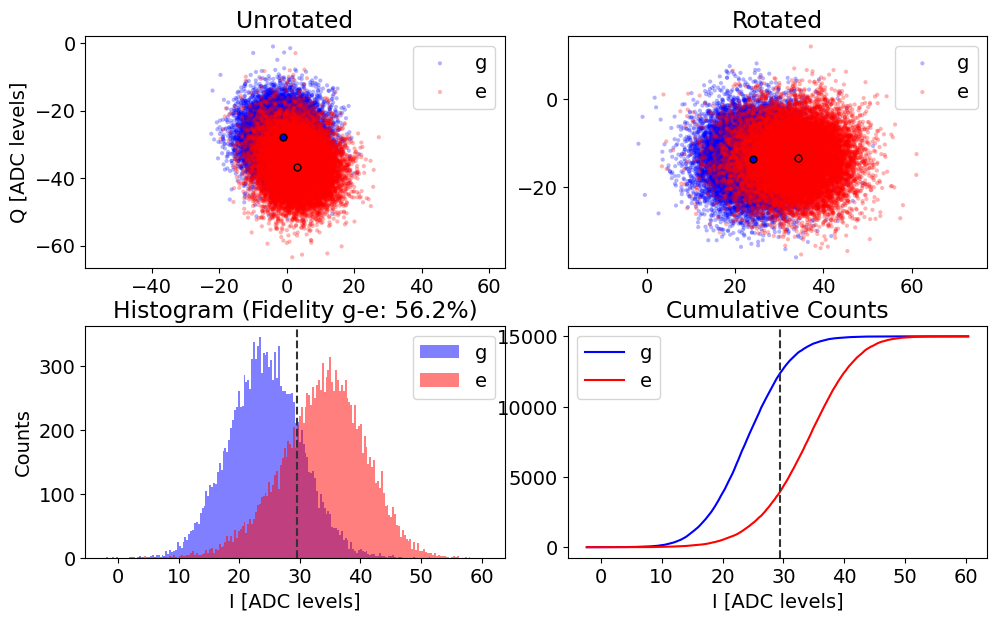

ge fidelity (%): 56.18374558303887 	 angle (deg): 63.30448491832892 	 threshold ge: 29.507699336805054
thresholds=[0, 0, 0, 29.507699336805054],
angles=[0, 0, 0, 63.30448491832892],
ge_avgs=[array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), [-1.310840832249675, -27.7774451668834, 3.141974165583008, -36.28870316428261]],
counts_calib=[[10511, 1684, 2414, 391], [3277, 496, 9643, 1584]]


  0%|          | 0/20 [00:00<?, ?it/s]

From amps: adjust amplitude to (current gain) / 0.985322085766176


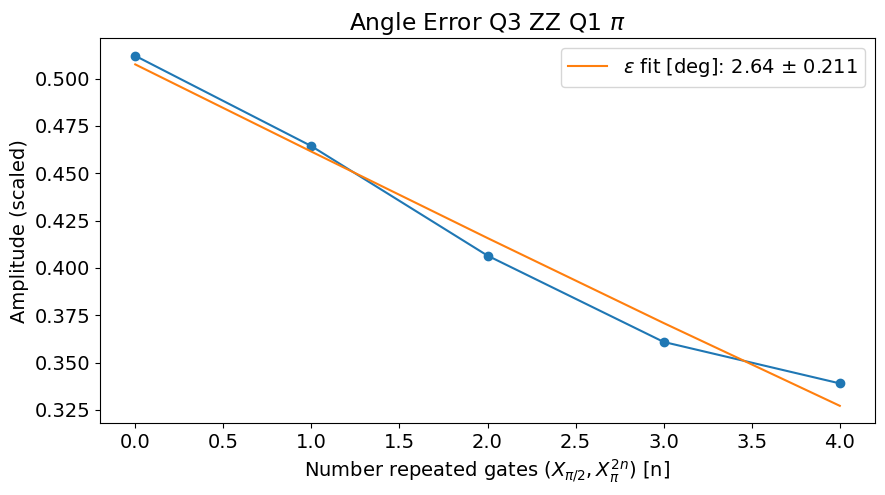

From avgi: adjust amplitude to (current gain) / 0.9877486939534466

From avgq: adjust amplitude to (current gain) / 0.9852584111599249


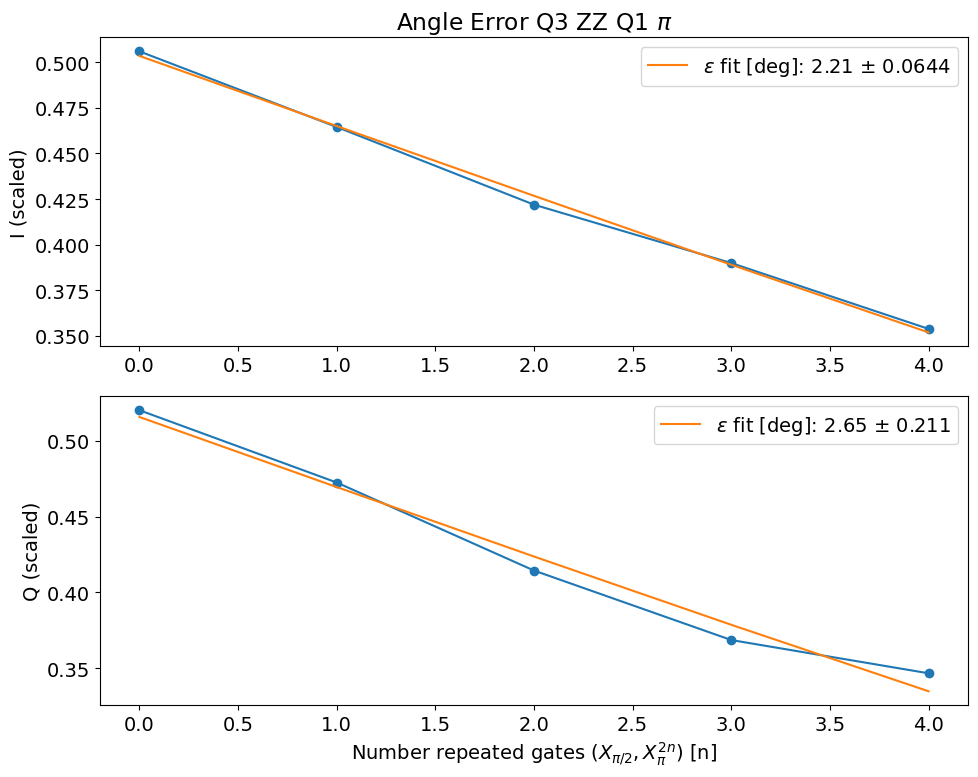

*Set Q3 pi pulse gain with Q1 in e pi_Q_ZZ1[3] to 3845*





In [41]:
 # [x, 1] means test Q1 with ZZ from Qx; [1, x] means test Qx with ZZ from Q1, sort by Qx in both cases

try: save_data
except: assert False, 'you did not run the cell above!'
q0 = 1
# for qx in [3]:
for qx in range(4):
    if qx == q1: continue

    print(f"######### BEGINNING QUBIT {qx} #########")
    # print(f"-------- Amp rabi --------")
    # amprabi = meas.AmplitudeRabiExperiment(
    #     soccfg=soc,
    #     path=expt_path,
    #     prefix=f"amp_rabi_qubit{q0}{qx}",
    #     config_file=config_path,
    # )
    # amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

    # span = min((32000, 1.5*yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.gain[qx]))
    # npts = 151

    # amprabi.cfg.expt = dict(
    #     start=0, # qubit gain [dac level]
    #     step=int(span/npts), # [dac level]
    #     expts=npts,
    #     reps=80,
    #     rounds=10,
    #     sigma_test=yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.sigma[qx], # gaussian sigma for pulse length - overrides config [us]
    #     pulse_type='gauss',
    #     checkZZ=True,
    #     checkEF=False, 
    #     qubits=[q0, qx],
    # )
    # try:
    #     import Pyro4.util
    #     try:
    #         amprabi.go(analyze=False, display=False, progress=True, save=False)
    #     except Exception:
    #         print("Pyro traceback:")
    #         print("".join(Pyro4.util.getPyroTraceback()))

    #     amprabi.analyze(fit=True)

    #     amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data)

    #     p = amprabi_fit
    #     if p[2] > 180: p[2] = p[2] - 360
    #     elif p[2] < -180: p[2] = p[2] + 360
    #     if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
    #     else: pi_gain = (3/2 - p[2]/180)/2/p[1]

    #     if pi_gain > 32000:
    #         amprabi.display(fit=False)
    #         print('WARNING: Fit pi pulse gain is long, please double check!')
    #         pi_gain = 30000
    #     else: amprabi.display(fit=True)

    #     yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.gain[qx] = int(pi_gain)
    #     results['gain'][qx] =  int(pi_gain)
    #     results['sigma'][qx] = yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.sigma[qx]
    #     print(f'*Set Q{qx} pi pulse gain with Q{q0} in e to {yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.gain[qx]}*')

    #     if save_data: saved_files.append(amprabi.save_data())

    # except Exception as e:
    #     print(e)
    #     print(f'!!!!!!! AMP RABI FAILED ON QUBIT {qx} (Q{q0} in e) !!!!!!!')
    #     continue

    # if qx < 2: continue
    print(f"-------- Ramsey --------")
    ramsey = meas.RamseyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"ramsey_qubit{q0}{qx}",
        config_file=config_path,
    )
    ramsey.cfg = AttrDict(deepcopy(yaml_cfg))
    
    ramsey.cfg.expt = dict(
        start=0, # wait time tau [us]
        step=soc.cycles2us(8), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
        # step=0.05, # [us]
        expts=151,
        # expts=151,
        ramsey_freq=3, # [MHz]
        reps=80,
        rounds=10,
        checkZZ=True,
        checkEF=False,
        qubits=[q0, qx],
    )
    
    # ramsey.cfg.device.readout.relax_delay = 3*ramsey.cfg.device.qubit.T1[q1] # Wait time b/w expts [us]
    # ramsey.cfg.device.readout.gain = 0.15 # IT SEEMS HIGH PHOTON POPULATION CAN SOMETIMES MESS THIS UP
    
    try:
        ramsey.go(analyze=False, display=False, progress=True, save=False)
        ramsey.analyze(fit=True)

        ramsey_fit, ramsey_fit_err, ramsey_adjust = meas.fitting.get_best_fit(ramsey.data, get_best_data_params=['f_adjust_ramsey'])

        ramsey.display(fit=True)
        new_pi_freq = ramsey.cfg.device.qubit.f_Q_ZZ1[qx] + ramsey_adjust[0]
        yaml_cfg.device.qubit.f_Q_ZZ1[qx] = new_pi_freq
        print(f'*Set Q{qx} pi pulse freq with Q{q0} in e to {yaml_cfg.device.qubit.f_Q_ZZ1[qx]}*')
        results['f_Q_ZZ1'][qx] = new_pi_freq

        if save_data: saved_files.append(ramsey.save_data())

    except Exception as e:
        print(e)
        print(f'!!!!!!! RAMSEY FAILED ON QUBIT {qx} (Q{q0} in e)!!!!!!!')
        continue

    print(f"-------- Amp rabi round 2 --------")
    amprabi = meas.AmplitudeRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"amp_rabi_qubit{q0}{qx}",
        config_file=config_path,
    )
    amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

    n_pulses = 1
    span = min((32000, 1.5*yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.gain[qx]/n_pulses))
    npts = 151

    amprabi.cfg.expt = dict(
        start=0, # qubit gain [dac level]
        step=int(span/npts), # [dac level]
        expts=npts,
        reps=80,
        rounds=10,
        sigma_test=yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.sigma[qx], # gaussian sigma for pulse length - overrides config [us]
        pulse_type='gauss',
        checkZZ=True,
        checkEF=False, 
        n_pulses=n_pulses,
        qubits=[q0, qx],
    )
    try:
        import Pyro4.util
        try:
            amprabi.go(analyze=False, display=False, progress=True, save=False)
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))

        amprabi.analyze(fit=True)

        amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data)

        p = amprabi_fit
        if p[2] > 180: p[2] = p[2] - 360
        elif p[2] < -180: p[2] = p[2] + 360
        if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
        else: pi_gain = (3/2 - p[2]/180)/2/p[1]

        if pi_gain > 32000:
            amprabi.display(fit=False)
            print('WARNING: Fit pi pulse gain is long, please double check!')
            pi_gain = 30000
        else: amprabi.display(fit=True)

        yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.gain[qx] = int(pi_gain*n_pulses)
        results['gain'][qx] =  int(pi_gain*n_pulses)
        results['sigma'][qx] = yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.sigma[qx]
        print(f'*Set Q{qx} pi pulse gain with Q{q0} in e to {yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.gain[qx]}*')

        if save_data: saved_files.append(amprabi.save_data())

    except Exception as e:
        print(e)
        print(f'!!!!!!! AMP RABI FAILED ON QUBIT {qx} (Q{q0} in e) !!!!!!!')
        continue

    print(f"-------- Error amplification --------")

    npulsecalib = meas.NPulseExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"NPulseExptQ{q0}{qx}",
        config_file=config_path,
    )

    npulsecalib.cfg = AttrDict(deepcopy(yaml_cfg))
    npulsecalib.cfg.expt = dict(
        start=0, # number gate repetitions
        step=1,
        expts=5,
        reps=2000,
        loops=20,
        pulse_type='gauss',
        checkZZ=True,
        checkEF=False, 
        qubits=[q0, qx],
        test_pi_half=False,

        post_process=True,
        singleshot_reps=15000,
        # thresholds=[43.44181385882051, 0, 0, 0],
        # angles=[124.56380665662411, 0, 0, 0],
        # ge_avgs=[[-13.276167611963428, -36.61750323880366, -19.7336279869828, -45.85555276615528], array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
        # counts_calib=[[0, 13279, 0, 1721], [0, 2252, 0, 12748]]
    )

    print(npulsecalib.cfg)
    import Pyro4.util
    try:
        npulsecalib.go(analyze=False, display=False, progress=True, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    data = npulsecalib.data

    npulsecalib.analyze(fit=True, scale=data['ge_avgs'])
    npulsecalib.display(fit=True, scale=data['ge_avgs'])
    
    npulsecalib_fit, npulsecalib_fit_err = meas.fitting.get_best_fit(npulsecalib.data)
    
    angle_err = npulsecalib_fit[1]
    amp_ratio = (180 - angle_err) / 180
    pi_gain = npulsecalib.cfg.device.qubit.pulses.pi_Q_ZZ1.gain[qx] / amp_ratio
    
    yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.gain[qx] = int(round(pi_gain))
    results['gain'][qx] = yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.gain[qx]
    print(f'*Set Q{qx} pi pulse gain with Q{q0} in e pi_Q_ZZ1[{qx}] to {yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.gain[qx]}*')

    
    print("\n\n")

In [42]:
print('pi_Q_ZZ1')
print(results)
for saved_file in saved_files:
    print(saved_file)

pi_Q_ZZ1
{'gain': [20048, 0, 11626, 3845], 'sigma': [0.02, 0, 0.01, 0.01], 'f_Q_ZZ1': [4111.34662537663, 0, 4765.430128871142, 4379.957017221256]}
s:\Connie\experiments\qramLL_4QR2\data\data_240218\00006_ramsey_qubit10.h5
None
s:\Connie\experiments\qramLL_4QR2\data\data_240218\00007_ramsey_qubit10.h5
None
s:\Connie\experiments\qramLL_4QR2\data\data_240218\00002_ramsey_qubit12.h5
None
s:\Connie\experiments\qramLL_4QR2\data\data_240218\00003_ramsey_qubit13.h5
None


also update the ZZ matrix using the better calibrated values

In [56]:
ZZshfits = np.reshape(np.array(yaml_cfg.device.qubit.ZZs), (4,4)) # MHz
f_Q1_ZZ = np.array(yaml_cfg.device.qubit.f_Q1_ZZ)
f_Q_ZZ1 = np.array(yaml_cfg.device.qubit.f_Q_ZZ1)
f_ge = np.array(yaml_cfg.device.qubit.f_ge)

ZZshifts[1, :] = f_Q1_ZZ - f_ge[1]
ZZshifts[:, 1] = f_Q_ZZ1 - f_ge

ZZshifts[1, 1] = 0
print(ZZshifts)

[[ 0.         -5.24478111 -0.13017092 -0.53007117]
 [-5.27196984  0.         -1.09094915 -1.28928513]
 [-0.13017092 -1.1003141   0.         -0.51457225]
 [-0.53007117 -1.31115053 -0.51457225  0.        ]]


In [57]:
print("UPDATE MANUALLY IN CONFIG:")
print(f'ZZs: [', end='')
print(*ZZshifts.flatten(), sep=', ', end='')
print(']')

UPDATE MANUALLY IN CONFIG:
ZZs: [0.0, -5.244781107236122, -0.13017092, -0.53007117, -5.271969842969611, 0.0, -1.0909491528386752, -1.289285132261739, -0.13017092, -1.1003141039536786, 0.0, -0.51457225, -0.53007117, -1.3111505310989742, -0.51457225, 0.0]
